In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense
from keras.layers.core import Dense, Dropout, Activation
from keras import callbacks
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import math
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K
import warnings
import seaborn as sns
import sys
warnings.filterwarnings('ignore')

/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = pd.read_csv('../../raw/LiChuan/TotalDataSet.csv')
submit = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')

In [3]:
data = data[data['year'] != 2012]

In [6]:
data_new=data.filter(regex='sale_date|class_id|price_level_.*')

In [7]:
data_new['sale_quantity']=data['sale_quantity']

In [8]:
data_new['num_time']=(data['year']-2012)*12+data['month']

In [9]:
data_new

,class_id,price_level_10-15W,price_level_15-20W,price_level_20-25W,price_level_25-35W,price_level_35-50W,price_level_5-8W,price_level_50-75W,price_level_5WL,price_level_8-10W,sale_date,sale_quantity,num_time
1680,125403,0,0,1,1,1,0,0,0,0,2013-01,238.0,13.0
1681,136916,0,1,1,1,0,0,0,0,0,2013-01,613.0,13.0
1682,178529,0,0,0,0,0,0,0,1,0,2013-01,1465.0,13.0
1683,194450,0,1,0,0,0,0,0,0,0,2013-01,106.0,13.0
1684,198427,0,0,0,0,0,1,0,0,0,2013-01,31.0,13.0
1685,209945,0,0,0,0,1,0,1,0,0,2013-01,283.0,13.0
1686,248352,1,0,0,0,0,1,0,0,1,2013-01,1428.0,13.0
1687,281301,0,0,1,1,0,0,0,0,0,2013-01,1555.0,13.0
1688,290854,0,1,1,0,0,0,0,0,0,2013-01,676.0,13.0
1689,291086,0,1,1,0,0,0,0,0,0,2013-01,1089.0,13.0


In [31]:
# class_id=data_new.class_id.unique()

# class_id

# s=dict(zip(class_id ,range(len(class_id ))))

# for i in s:
#     data_new.loc[data_new['class_id'] ==i,'class_id_reflect']=s[i]

In [10]:
class_id_dummies=pd.get_dummies(data_new['class_id'],prefix='class_id')
data_new=pd.concat([data_new,class_id_dummies],axis=1)


In [11]:
# data_new.drop('class_id_reflect',axis=1,inplace=True)

In [12]:
data_new

,class_id,price_level_10-15W,price_level_15-20W,price_level_20-25W,price_level_25-35W,price_level_35-50W,price_level_5-8W,price_level_50-75W,price_level_5WL,price_level_8-10W,...,class_id_923841,class_id_924154,class_id_948936,class_id_950264,class_id_953842,class_id_961362,class_id_961962,class_id_963845,class_id_973106,class_id_978089
1680,125403,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1681,136916,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1682,178529,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1683,194450,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1684,198427,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1685,209945,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1686,248352,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1687,281301,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1688,290854,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1689,291086,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
data=data_new

In [14]:
data

,class_id,price_level_10-15W,price_level_15-20W,price_level_20-25W,price_level_25-35W,price_level_35-50W,price_level_5-8W,price_level_50-75W,price_level_5WL,price_level_8-10W,...,class_id_923841,class_id_924154,class_id_948936,class_id_950264,class_id_953842,class_id_961362,class_id_961962,class_id_963845,class_id_973106,class_id_978089
1680,125403,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1681,136916,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1682,178529,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1683,194450,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1684,198427,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1685,209945,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1686,248352,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1687,281301,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1688,290854,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1689,291086,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# 

labels = data['sale_quantity']
data = data.drop(['sale_date', 'class_id', 'sale_quantity'], axis=1)

In [16]:
# 训练集 2013-01 至 2017-07, 测试集 2017-08
train_1 = data[:-560]
test_1 = data[-560:-420]
labels_1 = labels[:-560]
test_labels_1 = labels[-560:-420]

# 训练集 2013-01 至 2017-08, 测试集 2017-09
train_2 = data[:-420]
test_2 = data[-420:-280]
labels_2 = labels[:-420]
test_labels_2 = labels[-420:-280]

# 训练集 2013-01 至 2017-09, 测试集 2017-10
train_3 = data[:-280]
test_3 = data[-280:-140]
labels_3 = labels[:-280]
test_labels_3 = labels[-280:-140]

In [17]:
# 训练集 2013-01 至 2017-07, 测试集 2017-08
train_1 = train_1.as_matrix()
test_1 = test_1.as_matrix()
labels_1 = labels_1.as_matrix()
test_labels_1 = test_labels_1.as_matrix()
# 训练集 2013-01 至 2017-08, 测试集 2017-09
train_2 = train_2.as_matrix()
test_2 = test_2.as_matrix()
labels_2 = labels_2.as_matrix()
test_labels_2 = test_labels_2.as_matrix()

# 训练集 2013-01 至 2017-09, 测试集 2017-10
train_3 = train_3.as_matrix()
test_3 = test_3.as_matrix()
labels_3 = labels_3.as_matrix()
test_labels_3 = test_labels_3.as_matrix()

In [16]:
# scaler = MinMaxScaler(feature_range=(0, 1))

# train_1 = scaler.fit_transform(train_1)
# test_1 = scaler.fit_transform(test_1)

# train_2 = scaler.fit_transform(train_2)
# test_2 = scaler.fit_transform(test_2)

# train_3 = scaler.fit_transform(train_3)
# test_3 = scaler.fit_transform(test_3)

In [17]:
# labels_1 = scaler.fit_transform(labels_1)
# test_labels_1 = scaler.fit_transform(test_labels_1)

# labels_2 = scaler.fit_transform(labels_2)
# test_labels_2 = scaler.fit_transform(test_labels_2)

# labels_3 = scaler.fit_transform(labels_3)
# test_labels_3 = scaler.fit_transform(test_labels_3)

In [18]:

train_1 = train_1.reshape((train_1.shape[0], 1, train_1.shape[1]))
test_1 = test_1.reshape((test_1.shape[0], 1, test_1.shape[1]))
train_2 = train_2.reshape((train_2.shape[0], 1, train_2.shape[1]))
test_2 = test_2.reshape((test_2.shape[0], 1, test_2.shape[1]))
train_3 = train_3.reshape((train_3.shape[0], 1, train_3.shape[1]))
test_3 = test_3.reshape((test_3.shape[0], 1, test_3.shape[1]))

In [19]:
# BATCH_START = 0
# TIME_STEPS = 20 #取20步
# BATCH_SIZE = 50
# INPUT_SIZE = 1 #输入的值
# OUTPUT_SIZE = 1 #输出预测的值
# CELL_SIZE = 20
# LR = 0.006

In [20]:
def rmse_loss(ground_truth, pred):
    # return mean_squared_error(ground_truth, pred)
    return K.sqrt(K.mean(K.square(ground_truth-pred),axis=-1))



In [41]:
model = Sequential()
# model.add(LSTM(
#     batch_input_shape=(BATCH_SIZE, TIME_STEPS, INPUT_SIZE),       # Or: input_dim=INPUT_SIZE, input_length=TIME_STEPS,
#     output_dim=CELL_SIZE,
#     return_sequences=True,      # True: output at all steps. False: output as last step.
#     stateful=True,              # True: the final state of batch1 is feed into the initial state of batch2
# ))
model.add(LSTM(64, input_shape=(train_1.shape[1],train_1.shape[2])))
model.add(Dropout(.1))
model.add(Dense(64))
model.add(Dropout(.2))
model.add(Dense(16))
model.add(Dropout(.2))
model.add(Dense(1))
model.compile(loss = rmse_loss, optimizer='adam', metrics=['mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                52736     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total para

Train on 7700 samples, validate on 140 samples
Epoch 1/3000
 - 1s - loss: 281.1949 - mean_squared_error: 329182.9683 - val_loss: 337.5249 - val_mean_squared_error: 290168.5000
Epoch 2/3000
 - 0s - loss: 278.7482 - mean_squared_error: 324492.2148 - val_loss: 324.6362 - val_mean_squared_error: 280907.2188
Epoch 3/3000
 - 0s - loss: 273.9545 - mean_squared_error: 315960.9012 - val_loss: 300.9487 - val_mean_squared_error: 264079.5000
Epoch 4/3000
 - 0s - loss: 265.9687 - mean_squared_error: 303354.4186 - val_loss: 268.9427 - val_mean_squared_error: 240626.2031
Epoch 5/3000
 - 0s - loss: 255.9649 - mean_squared_error: 289965.6885 - val_loss: 241.6283 - val_mean_squared_error: 215074.3906
Epoch 6/3000
 - 0s - loss: 250.2629 - mean_squared_error: 272336.1070 - val_loss: 231.6830 - val_mean_squared_error: 204471.4375
Epoch 7/3000
 - 0s - loss: 244.4843 - mean_squared_error: 273376.7009 - val_loss: 224.7765 - val_mean_squared_error: 191880.9062
Epoch 8/3000
 - 0s - loss: 228.4183 - mean_squared

Epoch 65/3000
 - 0s - loss: 114.1660 - mean_squared_error: 67324.6445 - val_loss: 138.5831 - val_mean_squared_error: 64162.6133
Epoch 66/3000
 - 0s - loss: 110.9917 - mean_squared_error: 67629.7630 - val_loss: 139.4873 - val_mean_squared_error: 62831.9414
Epoch 67/3000
 - 0s - loss: 111.8407 - mean_squared_error: 70164.1582 - val_loss: 138.1832 - val_mean_squared_error: 62750.7930
Epoch 68/3000
 - 0s - loss: 111.3167 - mean_squared_error: 65803.3867 - val_loss: 138.9872 - val_mean_squared_error: 62290.1641
Epoch 69/3000
 - 0s - loss: 113.1339 - mean_squared_error: 64846.6926 - val_loss: 135.7348 - val_mean_squared_error: 61702.0508
Epoch 70/3000
 - 0s - loss: 111.2940 - mean_squared_error: 66127.2205 - val_loss: 136.6617 - val_mean_squared_error: 61093.2422
Epoch 71/3000
 - 0s - loss: 113.0571 - mean_squared_error: 65766.2597 - val_loss: 137.8230 - val_mean_squared_error: 61703.8867
Epoch 72/3000
 - 0s - loss: 117.1600 - mean_squared_error: 67629.5714 - val_loss: 138.8289 - val_mean_sq

Epoch 129/3000
 - 0s - loss: 110.4174 - mean_squared_error: 61505.6773 - val_loss: 130.3920 - val_mean_squared_error: 52442.3750
Epoch 130/3000
 - 0s - loss: 119.1673 - mean_squared_error: 62737.1963 - val_loss: 132.4011 - val_mean_squared_error: 56396.2305
Epoch 131/3000
 - 0s - loss: 111.6096 - mean_squared_error: 64042.2213 - val_loss: 128.8467 - val_mean_squared_error: 53122.0391
Epoch 132/3000
 - 0s - loss: 110.1008 - mean_squared_error: 60136.3425 - val_loss: 129.1082 - val_mean_squared_error: 52392.9141
Epoch 133/3000
 - 0s - loss: 115.9307 - mean_squared_error: 61881.3228 - val_loss: 131.7666 - val_mean_squared_error: 55525.1797
Epoch 134/3000
 - 0s - loss: 106.1580 - mean_squared_error: 59259.7667 - val_loss: 127.8945 - val_mean_squared_error: 51743.0977
Epoch 135/3000
 - 0s - loss: 111.8091 - mean_squared_error: 59369.9425 - val_loss: 127.7320 - val_mean_squared_error: 52705.3945
Epoch 136/3000
 - 0s - loss: 112.6984 - mean_squared_error: 60977.7248 - val_loss: 128.9239 - val

Epoch 193/3000
 - 0s - loss: 98.9612 - mean_squared_error: 52988.9073 - val_loss: 121.5400 - val_mean_squared_error: 43861.3984
Epoch 194/3000
 - 0s - loss: 99.6772 - mean_squared_error: 53456.0711 - val_loss: 120.9585 - val_mean_squared_error: 43916.7500
Epoch 195/3000
 - 0s - loss: 99.4055 - mean_squared_error: 55037.8505 - val_loss: 120.9548 - val_mean_squared_error: 43518.4531
Epoch 196/3000
 - 0s - loss: 98.7819 - mean_squared_error: 52603.4344 - val_loss: 119.9121 - val_mean_squared_error: 43071.4375
Epoch 197/3000
 - 0s - loss: 99.8880 - mean_squared_error: 53116.2294 - val_loss: 120.5048 - val_mean_squared_error: 43150.3711
Epoch 198/3000
 - 0s - loss: 98.5293 - mean_squared_error: 53747.4712 - val_loss: 120.8321 - val_mean_squared_error: 43187.1289
Epoch 199/3000
 - 0s - loss: 99.2157 - mean_squared_error: 56203.9589 - val_loss: 121.6204 - val_mean_squared_error: 43216.4648
Epoch 200/3000
 - 0s - loss: 98.5674 - mean_squared_error: 55092.6131 - val_loss: 122.2280 - val_mean_sq

Epoch 257/3000
 - 0s - loss: 99.6026 - mean_squared_error: 52411.9520 - val_loss: 115.0663 - val_mean_squared_error: 37084.0430
Epoch 258/3000
 - 0s - loss: 102.7795 - mean_squared_error: 52156.0178 - val_loss: 116.1643 - val_mean_squared_error: 37668.3008
Epoch 259/3000
 - 0s - loss: 96.6843 - mean_squared_error: 50610.2398 - val_loss: 114.0796 - val_mean_squared_error: 36541.5508
Epoch 260/3000
 - 0s - loss: 101.7645 - mean_squared_error: 50757.1836 - val_loss: 114.4678 - val_mean_squared_error: 36983.2891
Epoch 261/3000
 - 0s - loss: 96.9814 - mean_squared_error: 52423.0801 - val_loss: 114.3205 - val_mean_squared_error: 36704.4219
Epoch 262/3000
 - 0s - loss: 95.3024 - mean_squared_error: 50266.3919 - val_loss: 114.2826 - val_mean_squared_error: 36629.3594
Epoch 263/3000
 - 0s - loss: 94.8219 - mean_squared_error: 49635.8862 - val_loss: 114.9817 - val_mean_squared_error: 36779.2617
Epoch 264/3000
 - 0s - loss: 94.7756 - mean_squared_error: 48744.9400 - val_loss: 114.5935 - val_mean_

Epoch 321/3000
 - 0s - loss: 93.6298 - mean_squared_error: 47074.3343 - val_loss: 108.7665 - val_mean_squared_error: 32337.5781
Epoch 322/3000
 - 0s - loss: 95.0613 - mean_squared_error: 49502.8671 - val_loss: 108.8845 - val_mean_squared_error: 32988.7383
Epoch 323/3000
 - 0s - loss: 94.7718 - mean_squared_error: 49098.3253 - val_loss: 109.5032 - val_mean_squared_error: 32999.1094
Epoch 324/3000
 - 0s - loss: 95.9977 - mean_squared_error: 50589.2674 - val_loss: 109.2269 - val_mean_squared_error: 32909.0938
Epoch 325/3000
 - 0s - loss: 99.5753 - mean_squared_error: 50957.9019 - val_loss: 111.1849 - val_mean_squared_error: 33470.1055
Epoch 326/3000
 - 0s - loss: 95.5729 - mean_squared_error: 47731.0141 - val_loss: 114.3976 - val_mean_squared_error: 34566.6875
Epoch 327/3000
 - 0s - loss: 94.7507 - mean_squared_error: 50166.6999 - val_loss: 109.6991 - val_mean_squared_error: 32384.8281
Epoch 328/3000
 - 0s - loss: 100.1414 - mean_squared_error: 50802.9841 - val_loss: 111.9506 - val_mean_s

Epoch 385/3000
 - 0s - loss: 91.8439 - mean_squared_error: 48477.0949 - val_loss: 104.7194 - val_mean_squared_error: 29475.8496
Epoch 386/3000
 - 0s - loss: 91.5677 - mean_squared_error: 49170.4191 - val_loss: 103.8534 - val_mean_squared_error: 29410.0293
Epoch 387/3000
 - 0s - loss: 93.4850 - mean_squared_error: 48841.7960 - val_loss: 104.9055 - val_mean_squared_error: 29876.8750
Epoch 388/3000
 - 0s - loss: 96.5463 - mean_squared_error: 49027.0155 - val_loss: 103.6842 - val_mean_squared_error: 29418.0898
Epoch 389/3000
 - 0s - loss: 94.5603 - mean_squared_error: 47799.8094 - val_loss: 107.9038 - val_mean_squared_error: 30848.7109
Epoch 390/3000
 - 0s - loss: 97.4054 - mean_squared_error: 50572.5373 - val_loss: 106.6915 - val_mean_squared_error: 30005.8008
Epoch 391/3000
 - 0s - loss: 92.1894 - mean_squared_error: 46959.1200 - val_loss: 107.4759 - val_mean_squared_error: 30737.9277
Epoch 392/3000
 - 0s - loss: 91.2523 - mean_squared_error: 47553.2880 - val_loss: 104.8797 - val_mean_sq

Epoch 449/3000
 - 0s - loss: 99.6263 - mean_squared_error: 48375.1683 - val_loss: 106.6178 - val_mean_squared_error: 28653.8789
Epoch 450/3000
 - 0s - loss: 92.3500 - mean_squared_error: 47867.4614 - val_loss: 101.8343 - val_mean_squared_error: 28320.6348
Epoch 451/3000
 - 0s - loss: 99.1336 - mean_squared_error: 49610.6838 - val_loss: 101.1454 - val_mean_squared_error: 27983.9238
Epoch 452/3000
 - 0s - loss: 97.4483 - mean_squared_error: 47767.2529 - val_loss: 102.4075 - val_mean_squared_error: 28582.1895
Epoch 453/3000
 - 0s - loss: 103.4983 - mean_squared_error: 47606.8722 - val_loss: 106.4281 - val_mean_squared_error: 28632.5918
Epoch 454/3000
 - 0s - loss: 103.1164 - mean_squared_error: 53226.6792 - val_loss: 107.9157 - val_mean_squared_error: 30956.8848
Epoch 455/3000
 - 0s - loss: 99.0698 - mean_squared_error: 49449.8279 - val_loss: 103.1603 - val_mean_squared_error: 28338.8438
Epoch 456/3000
 - 0s - loss: 95.9700 - mean_squared_error: 47819.3395 - val_loss: 103.2878 - val_mean_

Epoch 514/3000
 - 0s - loss: 88.6436 - mean_squared_error: 45714.2800 - val_loss: 97.8455 - val_mean_squared_error: 26872.7246
Epoch 515/3000
 - 0s - loss: 89.7880 - mean_squared_error: 46357.4112 - val_loss: 97.6600 - val_mean_squared_error: 26732.1934
Epoch 516/3000
 - 0s - loss: 88.8673 - mean_squared_error: 45392.1054 - val_loss: 97.6829 - val_mean_squared_error: 26492.0723
Epoch 517/3000
 - 0s - loss: 89.0297 - mean_squared_error: 45386.4376 - val_loss: 97.5650 - val_mean_squared_error: 26604.9902
Epoch 518/3000
 - 0s - loss: 92.6414 - mean_squared_error: 48592.6819 - val_loss: 98.8159 - val_mean_squared_error: 26791.1191
Epoch 519/3000
 - 0s - loss: 91.3929 - mean_squared_error: 48214.2543 - val_loss: 99.0417 - val_mean_squared_error: 26556.5039
Epoch 520/3000
 - 0s - loss: 92.6182 - mean_squared_error: 47871.3927 - val_loss: 97.2689 - val_mean_squared_error: 25899.0254
Epoch 521/3000
 - 0s - loss: 89.3694 - mean_squared_error: 46770.9454 - val_loss: 96.8452 - val_mean_squared_er

Epoch 579/3000
 - 0s - loss: 87.6279 - mean_squared_error: 45895.7434 - val_loss: 97.0889 - val_mean_squared_error: 25881.7188
Epoch 580/3000
 - 0s - loss: 88.6193 - mean_squared_error: 45157.9413 - val_loss: 97.1333 - val_mean_squared_error: 25737.2930
Epoch 581/3000
 - 0s - loss: 88.9022 - mean_squared_error: 43462.6205 - val_loss: 99.0652 - val_mean_squared_error: 26022.1836
Epoch 582/3000
 - 0s - loss: 87.4006 - mean_squared_error: 44547.3028 - val_loss: 96.4803 - val_mean_squared_error: 24922.5078
Epoch 583/3000
 - 0s - loss: 92.2327 - mean_squared_error: 47120.5054 - val_loss: 96.7817 - val_mean_squared_error: 25262.3223
Epoch 584/3000
 - 0s - loss: 88.9875 - mean_squared_error: 45295.9542 - val_loss: 95.5270 - val_mean_squared_error: 24439.3730
Epoch 585/3000
 - 0s - loss: 91.1425 - mean_squared_error: 46569.0954 - val_loss: 96.2314 - val_mean_squared_error: 25033.8164
Epoch 586/3000
 - 0s - loss: 87.4036 - mean_squared_error: 44074.8180 - val_loss: 96.1002 - val_mean_squared_er

Epoch 644/3000
 - 0s - loss: 92.7784 - mean_squared_error: 47191.7491 - val_loss: 96.0248 - val_mean_squared_error: 25050.3457
Epoch 645/3000
 - 0s - loss: 88.1542 - mean_squared_error: 46001.5518 - val_loss: 95.1609 - val_mean_squared_error: 24344.5410
Epoch 646/3000
 - 0s - loss: 87.4648 - mean_squared_error: 44673.8370 - val_loss: 96.3058 - val_mean_squared_error: 25136.5137
Epoch 647/3000
 - 0s - loss: 86.9561 - mean_squared_error: 45355.7103 - val_loss: 95.3533 - val_mean_squared_error: 24264.3008
Epoch 648/3000
 - 0s - loss: 87.6527 - mean_squared_error: 44841.1120 - val_loss: 94.7650 - val_mean_squared_error: 24161.5078
Epoch 649/3000
 - 0s - loss: 87.4267 - mean_squared_error: 44026.2763 - val_loss: 96.2598 - val_mean_squared_error: 25250.2793
Epoch 650/3000
 - 0s - loss: 86.6449 - mean_squared_error: 44163.7038 - val_loss: 97.3585 - val_mean_squared_error: 25838.1641
Epoch 651/3000
 - 0s - loss: 87.2250 - mean_squared_error: 43762.9387 - val_loss: 96.3354 - val_mean_squared_er

Epoch 709/3000
 - 0s - loss: 90.9010 - mean_squared_error: 42662.4547 - val_loss: 96.2775 - val_mean_squared_error: 24585.7578
Epoch 710/3000
 - 0s - loss: 87.5284 - mean_squared_error: 44870.7152 - val_loss: 96.1051 - val_mean_squared_error: 24719.6465
Epoch 711/3000
 - 0s - loss: 87.9131 - mean_squared_error: 47287.4437 - val_loss: 94.6651 - val_mean_squared_error: 23720.2598
Epoch 712/3000
 - 0s - loss: 87.5906 - mean_squared_error: 45655.7293 - val_loss: 95.4838 - val_mean_squared_error: 24127.2324
Epoch 713/3000
 - 0s - loss: 87.8663 - mean_squared_error: 45161.2853 - val_loss: 94.4663 - val_mean_squared_error: 23697.4531
Epoch 714/3000
 - 0s - loss: 90.9403 - mean_squared_error: 46054.6687 - val_loss: 93.3469 - val_mean_squared_error: 23581.9062
Epoch 715/3000
 - 0s - loss: 86.9512 - mean_squared_error: 45513.1297 - val_loss: 94.3830 - val_mean_squared_error: 23726.3438
Epoch 716/3000
 - 0s - loss: 88.9041 - mean_squared_error: 44370.0764 - val_loss: 94.5727 - val_mean_squared_er

Epoch 774/3000
 - 0s - loss: 87.3336 - mean_squared_error: 48237.4962 - val_loss: 92.8826 - val_mean_squared_error: 22517.2969
Epoch 775/3000
 - 0s - loss: 89.3763 - mean_squared_error: 46021.3998 - val_loss: 92.3288 - val_mean_squared_error: 22516.9707
Epoch 776/3000
 - 0s - loss: 85.7404 - mean_squared_error: 45324.7749 - val_loss: 92.3300 - val_mean_squared_error: 22243.3105
Epoch 777/3000
 - 0s - loss: 89.0208 - mean_squared_error: 44519.7402 - val_loss: 92.1267 - val_mean_squared_error: 22136.2637
Epoch 778/3000
 - 0s - loss: 86.4113 - mean_squared_error: 45820.7192 - val_loss: 92.6080 - val_mean_squared_error: 22601.5742
Epoch 779/3000
 - 0s - loss: 85.2253 - mean_squared_error: 43856.8232 - val_loss: 92.6419 - val_mean_squared_error: 22517.3223
Epoch 780/3000
 - 0s - loss: 84.6811 - mean_squared_error: 43268.1205 - val_loss: 92.2564 - val_mean_squared_error: 22490.5137
Epoch 781/3000
 - 0s - loss: 85.4564 - mean_squared_error: 44311.7445 - val_loss: 92.9028 - val_mean_squared_er

Epoch 839/3000
 - 0s - loss: 85.5293 - mean_squared_error: 43986.2190 - val_loss: 93.7518 - val_mean_squared_error: 22620.8711
Epoch 840/3000
 - 0s - loss: 86.8988 - mean_squared_error: 45852.5883 - val_loss: 92.4564 - val_mean_squared_error: 21307.5840
Epoch 841/3000
 - 0s - loss: 89.3895 - mean_squared_error: 46074.7922 - val_loss: 91.7305 - val_mean_squared_error: 21694.5957
Epoch 842/3000
 - 0s - loss: 87.2736 - mean_squared_error: 44885.4286 - val_loss: 92.5437 - val_mean_squared_error: 22080.6895
Epoch 843/3000
 - 0s - loss: 88.3257 - mean_squared_error: 46618.5014 - val_loss: 93.5359 - val_mean_squared_error: 22131.9316
Epoch 844/3000
 - 0s - loss: 87.2980 - mean_squared_error: 47514.2689 - val_loss: 93.3007 - val_mean_squared_error: 21800.8320
Epoch 845/3000
 - 0s - loss: 88.5315 - mean_squared_error: 44964.4039 - val_loss: 91.7791 - val_mean_squared_error: 21688.8320
Epoch 846/3000
 - 0s - loss: 85.2462 - mean_squared_error: 44609.9209 - val_loss: 91.6833 - val_mean_squared_er

Epoch 904/3000
 - 0s - loss: 86.2399 - mean_squared_error: 43426.5549 - val_loss: 92.9059 - val_mean_squared_error: 22526.0469
Epoch 905/3000
 - 0s - loss: 86.9682 - mean_squared_error: 46465.8994 - val_loss: 92.7526 - val_mean_squared_error: 22236.4668
Epoch 906/3000
 - 0s - loss: 87.0127 - mean_squared_error: 44723.3330 - val_loss: 92.6746 - val_mean_squared_error: 22541.1211
Epoch 907/3000
 - 0s - loss: 90.3374 - mean_squared_error: 45793.9540 - val_loss: 92.9266 - val_mean_squared_error: 21744.7324
Epoch 908/3000
 - 0s - loss: 85.8494 - mean_squared_error: 45772.9060 - val_loss: 94.4889 - val_mean_squared_error: 22997.6895
Epoch 909/3000
 - 0s - loss: 85.3322 - mean_squared_error: 46372.6224 - val_loss: 92.1498 - val_mean_squared_error: 21776.5352
Epoch 910/3000
 - 0s - loss: 85.0810 - mean_squared_error: 43342.0284 - val_loss: 92.7461 - val_mean_squared_error: 22034.9746
Epoch 911/3000
 - 0s - loss: 85.4704 - mean_squared_error: 42830.2981 - val_loss: 92.0336 - val_mean_squared_er

Epoch 969/3000
 - 0s - loss: 88.4156 - mean_squared_error: 46990.0668 - val_loss: 91.4324 - val_mean_squared_error: 20910.1113
Epoch 970/3000
 - 0s - loss: 94.0631 - mean_squared_error: 45200.9977 - val_loss: 90.2540 - val_mean_squared_error: 21694.8672
Epoch 971/3000
 - 0s - loss: 87.4809 - mean_squared_error: 46327.9024 - val_loss: 100.8983 - val_mean_squared_error: 27390.1777
Epoch 972/3000
 - 0s - loss: 89.6845 - mean_squared_error: 49391.9976 - val_loss: 91.7714 - val_mean_squared_error: 20884.8594
Epoch 973/3000
 - 0s - loss: 94.2326 - mean_squared_error: 47192.7497 - val_loss: 91.7184 - val_mean_squared_error: 22314.7188
Epoch 974/3000
 - 0s - loss: 85.9027 - mean_squared_error: 42691.0315 - val_loss: 94.4056 - val_mean_squared_error: 24670.0059
Epoch 975/3000
 - 0s - loss: 87.8057 - mean_squared_error: 47170.9974 - val_loss: 92.8199 - val_mean_squared_error: 22195.6641
Epoch 976/3000
 - 0s - loss: 89.7034 - mean_squared_error: 44034.2605 - val_loss: 90.4428 - val_mean_squared_e

Epoch 1034/3000
 - 0s - loss: 85.7942 - mean_squared_error: 45792.7766 - val_loss: 90.2419 - val_mean_squared_error: 21669.2852
Epoch 1035/3000
 - 0s - loss: 83.4101 - mean_squared_error: 43660.0588 - val_loss: 90.7322 - val_mean_squared_error: 21828.2832
Epoch 1036/3000
 - 0s - loss: 84.8431 - mean_squared_error: 45809.3814 - val_loss: 91.9742 - val_mean_squared_error: 22510.1680
Epoch 1037/3000
 - 0s - loss: 85.6036 - mean_squared_error: 47240.0253 - val_loss: 90.4991 - val_mean_squared_error: 21417.0469
Epoch 1038/3000
 - 0s - loss: 86.8855 - mean_squared_error: 46153.6794 - val_loss: 90.2870 - val_mean_squared_error: 21767.7402
Epoch 1039/3000
 - 0s - loss: 84.4079 - mean_squared_error: 41710.0053 - val_loss: 90.2928 - val_mean_squared_error: 21109.6211
Epoch 1040/3000
 - 0s - loss: 84.2932 - mean_squared_error: 43787.5156 - val_loss: 89.4202 - val_mean_squared_error: 20543.1895
Epoch 1041/3000
 - 0s - loss: 83.8841 - mean_squared_error: 44054.3961 - val_loss: 90.4384 - val_mean_sq

 - 0s - loss: 82.5213 - mean_squared_error: 43239.2270 - val_loss: 90.2619 - val_mean_squared_error: 21548.0430
Epoch 1099/3000
 - 0s - loss: 84.4196 - mean_squared_error: 42093.2526 - val_loss: 90.1959 - val_mean_squared_error: 21729.8008
Epoch 1100/3000
 - 0s - loss: 83.0115 - mean_squared_error: 43629.8982 - val_loss: 90.4334 - val_mean_squared_error: 21482.4492
Epoch 1101/3000
 - 0s - loss: 85.1420 - mean_squared_error: 45382.7526 - val_loss: 90.7517 - val_mean_squared_error: 22229.1816
Epoch 1102/3000
 - 0s - loss: 84.3604 - mean_squared_error: 44511.6314 - val_loss: 90.7132 - val_mean_squared_error: 22159.2852
Epoch 1103/3000
 - 0s - loss: 85.9987 - mean_squared_error: 44949.0422 - val_loss: 89.4648 - val_mean_squared_error: 20994.0469
Epoch 1104/3000
 - 0s - loss: 84.9373 - mean_squared_error: 44142.2438 - val_loss: 90.9586 - val_mean_squared_error: 21540.2402
Epoch 1105/3000
 - 0s - loss: 87.4462 - mean_squared_error: 43072.9487 - val_loss: 90.3203 - val_mean_squared_error: 210

Epoch 1163/3000
 - 0s - loss: 86.1028 - mean_squared_error: 45539.3851 - val_loss: 93.1952 - val_mean_squared_error: 21375.7188
Epoch 1164/3000
 - 0s - loss: 84.0999 - mean_squared_error: 43680.0389 - val_loss: 90.3649 - val_mean_squared_error: 20793.5605
Epoch 1165/3000
 - 0s - loss: 87.0518 - mean_squared_error: 47871.6720 - val_loss: 91.4079 - val_mean_squared_error: 22058.6172
Epoch 1166/3000
 - 0s - loss: 85.5371 - mean_squared_error: 45915.6563 - val_loss: 91.6696 - val_mean_squared_error: 21379.5391
Epoch 1167/3000
 - 0s - loss: 85.1855 - mean_squared_error: 44548.7194 - val_loss: 90.7224 - val_mean_squared_error: 20841.2246
Epoch 1168/3000
 - 0s - loss: 85.0463 - mean_squared_error: 42873.5249 - val_loss: 94.1860 - val_mean_squared_error: 22381.0508
Epoch 1169/3000
 - 0s - loss: 85.5821 - mean_squared_error: 45150.9243 - val_loss: 90.3447 - val_mean_squared_error: 20359.0137
Epoch 1170/3000
 - 0s - loss: 88.3962 - mean_squared_error: 45342.0860 - val_loss: 91.4238 - val_mean_sq

 - 0s - loss: 82.9046 - mean_squared_error: 43771.7689 - val_loss: 89.2982 - val_mean_squared_error: 21015.7891
Epoch 1228/3000
 - 0s - loss: 84.5867 - mean_squared_error: 42937.8037 - val_loss: 90.1523 - val_mean_squared_error: 21799.1816
Epoch 1229/3000
 - 0s - loss: 84.5536 - mean_squared_error: 46327.8181 - val_loss: 89.0883 - val_mean_squared_error: 19744.0469
Epoch 1230/3000
 - 0s - loss: 86.6237 - mean_squared_error: 47230.4621 - val_loss: 91.0432 - val_mean_squared_error: 21429.2324
Epoch 1231/3000
 - 0s - loss: 84.7407 - mean_squared_error: 43638.6863 - val_loss: 90.8576 - val_mean_squared_error: 21531.8789
Epoch 1232/3000
 - 0s - loss: 87.3386 - mean_squared_error: 44857.2299 - val_loss: 90.5426 - val_mean_squared_error: 21518.2266
Epoch 1233/3000
 - 0s - loss: 84.8727 - mean_squared_error: 44049.6388 - val_loss: 90.9323 - val_mean_squared_error: 21605.1191
Epoch 1234/3000
 - 0s - loss: 86.5141 - mean_squared_error: 48379.3020 - val_loss: 90.6671 - val_mean_squared_error: 215

Epoch 1292/3000
 - 0s - loss: 83.8104 - mean_squared_error: 44211.6253 - val_loss: 90.4314 - val_mean_squared_error: 21204.1328
Epoch 1293/3000
 - 0s - loss: 83.2861 - mean_squared_error: 42747.4241 - val_loss: 89.6002 - val_mean_squared_error: 20951.7070
Epoch 1294/3000
 - 0s - loss: 85.3444 - mean_squared_error: 45846.7553 - val_loss: 90.5473 - val_mean_squared_error: 21956.2617
Epoch 1295/3000
 - 0s - loss: 85.8836 - mean_squared_error: 43660.0884 - val_loss: 89.7591 - val_mean_squared_error: 21308.2051
Epoch 1296/3000
 - 0s - loss: 83.4932 - mean_squared_error: 42869.0396 - val_loss: 90.2409 - val_mean_squared_error: 21930.3359
Epoch 1297/3000
 - 0s - loss: 83.8135 - mean_squared_error: 44770.0138 - val_loss: 89.9658 - val_mean_squared_error: 21467.6582
Epoch 1298/3000
 - 0s - loss: 83.4086 - mean_squared_error: 43441.5800 - val_loss: 89.5262 - val_mean_squared_error: 21132.0605
Epoch 1299/3000
 - 0s - loss: 84.0503 - mean_squared_error: 45003.9853 - val_loss: 90.7871 - val_mean_sq

 - 0s - loss: 83.7067 - mean_squared_error: 41531.0755 - val_loss: 89.4594 - val_mean_squared_error: 21319.9453
Epoch 1357/3000
 - 0s - loss: 82.3916 - mean_squared_error: 42473.3469 - val_loss: 89.5574 - val_mean_squared_error: 22084.6133
Epoch 1358/3000
 - 0s - loss: 83.6932 - mean_squared_error: 44279.6227 - val_loss: 90.0115 - val_mean_squared_error: 22109.0293
Epoch 1359/3000
 - 0s - loss: 83.8595 - mean_squared_error: 45540.5146 - val_loss: 89.3151 - val_mean_squared_error: 21308.9434
Epoch 1360/3000
 - 0s - loss: 83.6938 - mean_squared_error: 44392.0922 - val_loss: 88.5639 - val_mean_squared_error: 19859.1348
Epoch 1361/3000
 - 0s - loss: 87.9282 - mean_squared_error: 46595.0697 - val_loss: 89.2727 - val_mean_squared_error: 21388.1602
Epoch 1362/3000
 - 0s - loss: 85.1210 - mean_squared_error: 46761.7131 - val_loss: 90.0364 - val_mean_squared_error: 21710.3027
Epoch 1363/3000
 - 0s - loss: 84.4521 - mean_squared_error: 42875.3416 - val_loss: 89.0123 - val_mean_squared_error: 204

Epoch 1421/3000
 - 0s - loss: 81.5150 - mean_squared_error: 41578.6655 - val_loss: 89.3222 - val_mean_squared_error: 20715.5898
Epoch 1422/3000
 - 0s - loss: 82.5653 - mean_squared_error: 45387.8087 - val_loss: 89.4131 - val_mean_squared_error: 21520.8926
Epoch 1423/3000
 - 0s - loss: 82.7371 - mean_squared_error: 41762.4965 - val_loss: 89.6389 - val_mean_squared_error: 21339.9492
Epoch 1424/3000
 - 0s - loss: 82.2013 - mean_squared_error: 44243.7608 - val_loss: 89.9850 - val_mean_squared_error: 21263.8457
Epoch 1425/3000
 - 0s - loss: 83.0349 - mean_squared_error: 46550.0531 - val_loss: 90.2635 - val_mean_squared_error: 21746.0938
Epoch 1426/3000
 - 0s - loss: 84.6239 - mean_squared_error: 45593.3487 - val_loss: 89.2438 - val_mean_squared_error: 20792.7754
Epoch 1427/3000
 - 0s - loss: 83.0916 - mean_squared_error: 42756.5733 - val_loss: 89.0191 - val_mean_squared_error: 20869.7402
Epoch 1428/3000
 - 0s - loss: 83.0384 - mean_squared_error: 44387.5312 - val_loss: 88.9686 - val_mean_sq

 - 0s - loss: 82.2934 - mean_squared_error: 42409.0683 - val_loss: 88.6276 - val_mean_squared_error: 20354.7148
Epoch 1486/3000
 - 0s - loss: 84.1599 - mean_squared_error: 41657.2766 - val_loss: 89.6427 - val_mean_squared_error: 21286.0723
Epoch 1487/3000
 - 0s - loss: 87.7598 - mean_squared_error: 45269.9554 - val_loss: 89.3416 - val_mean_squared_error: 21184.1816
Epoch 1488/3000
 - 0s - loss: 86.0036 - mean_squared_error: 45770.0127 - val_loss: 89.1649 - val_mean_squared_error: 21063.0801
Epoch 1489/3000
 - 0s - loss: 83.5208 - mean_squared_error: 45316.8856 - val_loss: 88.3185 - val_mean_squared_error: 20226.8750
Epoch 1490/3000
 - 0s - loss: 82.7597 - mean_squared_error: 43287.9773 - val_loss: 89.3606 - val_mean_squared_error: 21606.6797
Epoch 1491/3000
 - 0s - loss: 84.2468 - mean_squared_error: 43691.1833 - val_loss: 89.2714 - val_mean_squared_error: 21178.7520
Epoch 1492/3000
 - 0s - loss: 82.8936 - mean_squared_error: 42668.0028 - val_loss: 88.2703 - val_mean_squared_error: 204

Epoch 1550/3000
 - 0s - loss: 82.0343 - mean_squared_error: 43283.3258 - val_loss: 89.2779 - val_mean_squared_error: 20588.5410
Epoch 1551/3000
 - 0s - loss: 83.0506 - mean_squared_error: 45033.8392 - val_loss: 88.6692 - val_mean_squared_error: 20303.7988
Epoch 1552/3000
 - 0s - loss: 83.4615 - mean_squared_error: 43742.5194 - val_loss: 90.1422 - val_mean_squared_error: 22462.5000
Epoch 1553/3000
 - 0s - loss: 81.6513 - mean_squared_error: 41458.6185 - val_loss: 88.8781 - val_mean_squared_error: 20527.8223
Epoch 1554/3000
 - 0s - loss: 81.1093 - mean_squared_error: 42749.2112 - val_loss: 89.3001 - val_mean_squared_error: 21282.9688
Epoch 1555/3000
 - 0s - loss: 82.1692 - mean_squared_error: 42725.6550 - val_loss: 89.4457 - val_mean_squared_error: 21606.6250
Epoch 1556/3000
 - 0s - loss: 82.3117 - mean_squared_error: 46556.7131 - val_loss: 90.3206 - val_mean_squared_error: 22209.8262
Epoch 1557/3000
 - 0s - loss: 82.5373 - mean_squared_error: 46483.5895 - val_loss: 89.4363 - val_mean_sq

 - 0s - loss: 82.3338 - mean_squared_error: 43100.1294 - val_loss: 90.2311 - val_mean_squared_error: 20459.7793
Epoch 1615/3000
 - 0s - loss: 82.3909 - mean_squared_error: 41701.8941 - val_loss: 90.8463 - val_mean_squared_error: 21149.1777
Epoch 1616/3000
 - 0s - loss: 81.3673 - mean_squared_error: 42737.3151 - val_loss: 88.7893 - val_mean_squared_error: 20220.3223
Epoch 1617/3000
 - 0s - loss: 83.1954 - mean_squared_error: 43848.5017 - val_loss: 89.6694 - val_mean_squared_error: 20922.0176
Epoch 1618/3000
 - 0s - loss: 83.2866 - mean_squared_error: 45064.1758 - val_loss: 90.3433 - val_mean_squared_error: 20727.1074
Epoch 1619/3000
 - 0s - loss: 81.4418 - mean_squared_error: 44235.1711 - val_loss: 89.1737 - val_mean_squared_error: 20469.3887
Epoch 1620/3000
 - 0s - loss: 82.9386 - mean_squared_error: 46135.5100 - val_loss: 89.8432 - val_mean_squared_error: 20794.3066
Epoch 1621/3000
 - 0s - loss: 81.5368 - mean_squared_error: 42117.7597 - val_loss: 89.4906 - val_mean_squared_error: 196

Epoch 1679/3000
 - 0s - loss: 81.7606 - mean_squared_error: 43177.1496 - val_loss: 89.3958 - val_mean_squared_error: 21260.1250
Epoch 1680/3000
 - 0s - loss: 81.8196 - mean_squared_error: 42199.9297 - val_loss: 88.9899 - val_mean_squared_error: 21785.5215
Epoch 1681/3000
 - 0s - loss: 82.5809 - mean_squared_error: 43905.5685 - val_loss: 89.2564 - val_mean_squared_error: 22089.4277
Epoch 1682/3000
 - 0s - loss: 81.7052 - mean_squared_error: 42473.5173 - val_loss: 89.3241 - val_mean_squared_error: 21227.3184
Epoch 1683/3000
 - 0s - loss: 83.4292 - mean_squared_error: 44090.1917 - val_loss: 89.4585 - val_mean_squared_error: 21568.6211
Epoch 1684/3000
 - 0s - loss: 82.9321 - mean_squared_error: 43805.3000 - val_loss: 87.9906 - val_mean_squared_error: 20817.5977
Epoch 1685/3000
 - 0s - loss: 83.1108 - mean_squared_error: 42874.8792 - val_loss: 88.2176 - val_mean_squared_error: 20440.4648
Epoch 1686/3000
 - 0s - loss: 81.0467 - mean_squared_error: 42669.7978 - val_loss: 88.2996 - val_mean_sq

 - 0s - loss: 81.9447 - mean_squared_error: 43965.9183 - val_loss: 89.0038 - val_mean_squared_error: 21375.3027
Epoch 1744/3000
 - 0s - loss: 80.2308 - mean_squared_error: 40776.1552 - val_loss: 88.5255 - val_mean_squared_error: 21020.7852
Epoch 1745/3000
 - 0s - loss: 82.7019 - mean_squared_error: 42802.4937 - val_loss: 89.4591 - val_mean_squared_error: 21225.5234
Epoch 1746/3000
 - 0s - loss: 82.0123 - mean_squared_error: 46521.2743 - val_loss: 87.2697 - val_mean_squared_error: 19988.7285
Epoch 1747/3000
 - 0s - loss: 82.3920 - mean_squared_error: 42845.3210 - val_loss: 88.0949 - val_mean_squared_error: 20430.8145
Epoch 1748/3000
 - 0s - loss: 83.3201 - mean_squared_error: 43495.2168 - val_loss: 88.3152 - val_mean_squared_error: 20728.6934
Epoch 1749/3000
 - 0s - loss: 83.8537 - mean_squared_error: 45709.2838 - val_loss: 90.8230 - val_mean_squared_error: 22091.6172
Epoch 1750/3000
 - 0s - loss: 84.8417 - mean_squared_error: 46051.9200 - val_loss: 87.7759 - val_mean_squared_error: 203

Epoch 1808/3000
 - 0s - loss: 82.6255 - mean_squared_error: 44010.5325 - val_loss: 88.3003 - val_mean_squared_error: 20497.0371
Epoch 1809/3000
 - 0s - loss: 82.8744 - mean_squared_error: 42616.3960 - val_loss: 88.8345 - val_mean_squared_error: 21120.6172
Epoch 1810/3000
 - 0s - loss: 80.7937 - mean_squared_error: 43341.0810 - val_loss: 87.7687 - val_mean_squared_error: 21064.6445
Epoch 1811/3000
 - 0s - loss: 81.4114 - mean_squared_error: 41531.2849 - val_loss: 88.4902 - val_mean_squared_error: 21168.4688
Epoch 1812/3000
 - 0s - loss: 81.8011 - mean_squared_error: 42428.4564 - val_loss: 88.5282 - val_mean_squared_error: 21595.6855
Epoch 1813/3000
 - 0s - loss: 82.8941 - mean_squared_error: 44769.2202 - val_loss: 87.5458 - val_mean_squared_error: 19709.7324
Epoch 1814/3000
 - 0s - loss: 83.1960 - mean_squared_error: 43903.1842 - val_loss: 88.5468 - val_mean_squared_error: 21292.0605
Epoch 1815/3000
 - 0s - loss: 81.6599 - mean_squared_error: 44489.2209 - val_loss: 87.7271 - val_mean_sq

 - 0s - loss: 82.4823 - mean_squared_error: 43103.8535 - val_loss: 88.0343 - val_mean_squared_error: 21268.1406
Epoch 1873/3000
 - 0s - loss: 81.7779 - mean_squared_error: 45195.9111 - val_loss: 87.7396 - val_mean_squared_error: 21404.3438
Epoch 1874/3000
 - 0s - loss: 80.5266 - mean_squared_error: 41942.9771 - val_loss: 88.2200 - val_mean_squared_error: 22105.6973
Epoch 1875/3000
 - 0s - loss: 80.6539 - mean_squared_error: 41838.0068 - val_loss: 87.6074 - val_mean_squared_error: 21279.4492
Epoch 1876/3000
 - 0s - loss: 81.8983 - mean_squared_error: 45745.6050 - val_loss: 87.6652 - val_mean_squared_error: 21124.2402
Epoch 1877/3000
 - 0s - loss: 80.6440 - mean_squared_error: 41732.6106 - val_loss: 87.9787 - val_mean_squared_error: 21284.5938
Epoch 1878/3000
 - 0s - loss: 81.6187 - mean_squared_error: 45845.1049 - val_loss: 87.2875 - val_mean_squared_error: 20713.9004
Epoch 1879/3000
 - 0s - loss: 81.0261 - mean_squared_error: 42747.2206 - val_loss: 87.9945 - val_mean_squared_error: 214

Epoch 1937/3000
 - 0s - loss: 80.3744 - mean_squared_error: 43242.2516 - val_loss: 87.5298 - val_mean_squared_error: 21005.1289
Epoch 1938/3000
 - 0s - loss: 83.0370 - mean_squared_error: 44546.5485 - val_loss: 87.0567 - val_mean_squared_error: 19845.0527
Epoch 1939/3000
 - 0s - loss: 81.3427 - mean_squared_error: 43922.0473 - val_loss: 88.3512 - val_mean_squared_error: 20940.3223
Epoch 1940/3000
 - 0s - loss: 81.0828 - mean_squared_error: 42645.1334 - val_loss: 89.0856 - val_mean_squared_error: 21863.1973
Epoch 1941/3000
 - 0s - loss: 81.2681 - mean_squared_error: 44961.4819 - val_loss: 89.2784 - val_mean_squared_error: 22265.2793
Epoch 1942/3000
 - 0s - loss: 82.0300 - mean_squared_error: 43570.8560 - val_loss: 88.6423 - val_mean_squared_error: 21459.4551
Epoch 1943/3000
 - 0s - loss: 83.4788 - mean_squared_error: 43615.6631 - val_loss: 87.8784 - val_mean_squared_error: 19355.7715
Epoch 1944/3000
 - 0s - loss: 81.0483 - mean_squared_error: 41898.7420 - val_loss: 88.0117 - val_mean_sq

 - 0s - loss: 81.8442 - mean_squared_error: 43087.7929 - val_loss: 87.2380 - val_mean_squared_error: 20323.7559
Epoch 2002/3000
 - 0s - loss: 82.6644 - mean_squared_error: 45939.8652 - val_loss: 87.6524 - val_mean_squared_error: 21425.2891
Epoch 2003/3000
 - 0s - loss: 82.2835 - mean_squared_error: 46227.0432 - val_loss: 87.5000 - val_mean_squared_error: 20278.4062
Epoch 2004/3000
 - 0s - loss: 80.9182 - mean_squared_error: 42184.9974 - val_loss: 87.6273 - val_mean_squared_error: 21144.5742
Epoch 2005/3000
 - 0s - loss: 80.2196 - mean_squared_error: 43551.1761 - val_loss: 87.1688 - val_mean_squared_error: 20721.5391
Epoch 2006/3000
 - 0s - loss: 81.6061 - mean_squared_error: 44905.0410 - val_loss: 87.1078 - val_mean_squared_error: 19821.3652
Epoch 2007/3000
 - 0s - loss: 82.6270 - mean_squared_error: 45432.2782 - val_loss: 87.2676 - val_mean_squared_error: 20238.9004
Epoch 2008/3000
 - 0s - loss: 83.5154 - mean_squared_error: 44593.7110 - val_loss: 87.3951 - val_mean_squared_error: 211

Epoch 2066/3000
 - 0s - loss: 85.6487 - mean_squared_error: 47100.7766 - val_loss: 87.6738 - val_mean_squared_error: 20276.9707
Epoch 2067/3000
 - 0s - loss: 81.5623 - mean_squared_error: 42638.7340 - val_loss: 87.5652 - val_mean_squared_error: 21017.1113
Epoch 2068/3000
 - 0s - loss: 78.9561 - mean_squared_error: 40603.9117 - val_loss: 87.0196 - val_mean_squared_error: 19659.5059
Epoch 2069/3000
 - 0s - loss: 81.2229 - mean_squared_error: 44601.0667 - val_loss: 86.8359 - val_mean_squared_error: 20222.7734
Epoch 2070/3000
 - 0s - loss: 82.3513 - mean_squared_error: 46011.9549 - val_loss: 86.7349 - val_mean_squared_error: 20556.5938
Epoch 2071/3000
 - 0s - loss: 82.9305 - mean_squared_error: 46001.7112 - val_loss: 86.3393 - val_mean_squared_error: 19574.1387
Epoch 2072/3000
 - 0s - loss: 80.5268 - mean_squared_error: 42836.6032 - val_loss: 85.4530 - val_mean_squared_error: 18461.8496
Epoch 2073/3000
 - 0s - loss: 80.6642 - mean_squared_error: 42317.3868 - val_loss: 86.2920 - val_mean_sq

 - 0s - loss: 80.9592 - mean_squared_error: 44206.3953 - val_loss: 88.4054 - val_mean_squared_error: 21980.1973
Epoch 2131/3000
 - 0s - loss: 82.1003 - mean_squared_error: 44287.8192 - val_loss: 88.1728 - val_mean_squared_error: 20399.2207
Epoch 2132/3000
 - 0s - loss: 80.2786 - mean_squared_error: 41989.0790 - val_loss: 86.7389 - val_mean_squared_error: 19498.6465
Epoch 2133/3000
 - 0s - loss: 79.8019 - mean_squared_error: 43695.3669 - val_loss: 87.9513 - val_mean_squared_error: 21186.8027
Epoch 2134/3000
 - 0s - loss: 80.5075 - mean_squared_error: 43729.3042 - val_loss: 87.8354 - val_mean_squared_error: 21147.5527
Epoch 2135/3000
 - 0s - loss: 80.0606 - mean_squared_error: 42485.9271 - val_loss: 87.4640 - val_mean_squared_error: 21095.3516
Epoch 2136/3000
 - 0s - loss: 81.0473 - mean_squared_error: 44631.3584 - val_loss: 87.5570 - val_mean_squared_error: 20562.5859
Epoch 2137/3000
 - 0s - loss: 80.7332 - mean_squared_error: 44144.5598 - val_loss: 89.4908 - val_mean_squared_error: 222

Epoch 2195/3000
 - 0s - loss: 81.1867 - mean_squared_error: 45240.7173 - val_loss: 86.9647 - val_mean_squared_error: 19831.3848
Epoch 2196/3000
 - 0s - loss: 81.2117 - mean_squared_error: 44118.6492 - val_loss: 85.9052 - val_mean_squared_error: 19416.4062
Epoch 2197/3000
 - 0s - loss: 80.8940 - mean_squared_error: 42996.2248 - val_loss: 86.1261 - val_mean_squared_error: 18904.5176
Epoch 2198/3000
 - 0s - loss: 78.6982 - mean_squared_error: 40618.2276 - val_loss: 87.4831 - val_mean_squared_error: 20427.2734
Epoch 2199/3000
 - 0s - loss: 80.4230 - mean_squared_error: 46133.4335 - val_loss: 90.3612 - val_mean_squared_error: 22066.8750
Epoch 2200/3000
 - 0s - loss: 80.0438 - mean_squared_error: 42638.3868 - val_loss: 86.7796 - val_mean_squared_error: 19340.8027
Epoch 2201/3000
 - 0s - loss: 80.0766 - mean_squared_error: 42948.4737 - val_loss: 87.0543 - val_mean_squared_error: 20368.9531
Epoch 2202/3000
 - 0s - loss: 80.8682 - mean_squared_error: 43287.1051 - val_loss: 88.5386 - val_mean_sq

 - 0s - loss: 79.8871 - mean_squared_error: 43710.3339 - val_loss: 88.1085 - val_mean_squared_error: 19724.1719
Epoch 2260/3000
 - 0s - loss: 81.9590 - mean_squared_error: 45150.2293 - val_loss: 88.8274 - val_mean_squared_error: 21042.6211
Epoch 2261/3000
 - 0s - loss: 80.3436 - mean_squared_error: 43503.4724 - val_loss: 89.3843 - val_mean_squared_error: 20401.4746
Epoch 2262/3000
 - 0s - loss: 79.2272 - mean_squared_error: 42875.9616 - val_loss: 87.5877 - val_mean_squared_error: 20330.2031
Epoch 2263/3000
 - 0s - loss: 81.6181 - mean_squared_error: 43731.6060 - val_loss: 87.8481 - val_mean_squared_error: 19740.3535
Epoch 2264/3000
 - 0s - loss: 80.5126 - mean_squared_error: 43319.8957 - val_loss: 87.6349 - val_mean_squared_error: 20167.8125
Epoch 2265/3000
 - 0s - loss: 81.0226 - mean_squared_error: 45438.8513 - val_loss: 87.9978 - val_mean_squared_error: 19949.7461
Epoch 2266/3000
 - 0s - loss: 79.5439 - mean_squared_error: 43300.4445 - val_loss: 88.2383 - val_mean_squared_error: 209

Epoch 2324/3000
 - 0s - loss: 82.0953 - mean_squared_error: 44722.8821 - val_loss: 86.3264 - val_mean_squared_error: 20374.6758
Epoch 2325/3000
 - 0s - loss: 80.9344 - mean_squared_error: 43642.2244 - val_loss: 86.3850 - val_mean_squared_error: 20769.6934
Epoch 2326/3000
 - 0s - loss: 80.6678 - mean_squared_error: 46808.6856 - val_loss: 86.7187 - val_mean_squared_error: 20261.2578
Epoch 2327/3000
 - 0s - loss: 80.7021 - mean_squared_error: 44320.8315 - val_loss: 86.2099 - val_mean_squared_error: 20253.9902
Epoch 2328/3000
 - 0s - loss: 80.0542 - mean_squared_error: 43298.7766 - val_loss: 85.5808 - val_mean_squared_error: 19277.3691
Epoch 2329/3000
 - 0s - loss: 78.8120 - mean_squared_error: 41039.6741 - val_loss: 85.8352 - val_mean_squared_error: 19994.0293
Epoch 2330/3000
 - 0s - loss: 80.1380 - mean_squared_error: 43276.2267 - val_loss: 86.5016 - val_mean_squared_error: 20938.0312
Epoch 2331/3000
 - 0s - loss: 80.1868 - mean_squared_error: 41283.1748 - val_loss: 87.5673 - val_mean_sq

 - 0s - loss: 80.3105 - mean_squared_error: 45240.1585 - val_loss: 86.6471 - val_mean_squared_error: 19047.2012
Epoch 2389/3000
 - 0s - loss: 79.9153 - mean_squared_error: 42230.5786 - val_loss: 86.4414 - val_mean_squared_error: 19881.0488
Epoch 2390/3000
 - 0s - loss: 79.3928 - mean_squared_error: 41560.0345 - val_loss: 88.5224 - val_mean_squared_error: 21253.1289
Epoch 2391/3000
 - 0s - loss: 79.6586 - mean_squared_error: 44487.3174 - val_loss: 86.7462 - val_mean_squared_error: 19862.8496
Epoch 2392/3000
 - 0s - loss: 79.7857 - mean_squared_error: 43842.1549 - val_loss: 85.7913 - val_mean_squared_error: 18975.2598
Epoch 2393/3000
 - 0s - loss: 80.0337 - mean_squared_error: 42404.4311 - val_loss: 86.4945 - val_mean_squared_error: 20592.8613
Epoch 2394/3000
 - 0s - loss: 78.8296 - mean_squared_error: 42177.0959 - val_loss: 87.3505 - val_mean_squared_error: 21364.8555
Epoch 2395/3000
 - 0s - loss: 80.0314 - mean_squared_error: 44788.0649 - val_loss: 86.1545 - val_mean_squared_error: 200

Epoch 2453/3000
 - 0s - loss: 80.1916 - mean_squared_error: 44903.4395 - val_loss: 87.2236 - val_mean_squared_error: 21885.2578
Epoch 2454/3000
 - 0s - loss: 78.7608 - mean_squared_error: 43083.8428 - val_loss: 88.8954 - val_mean_squared_error: 21479.0527
Epoch 2455/3000
 - 0s - loss: 80.1182 - mean_squared_error: 45573.1838 - val_loss: 88.6042 - val_mean_squared_error: 21086.0391
Epoch 2456/3000
 - 0s - loss: 78.6897 - mean_squared_error: 41544.1074 - val_loss: 86.8492 - val_mean_squared_error: 19523.6602
Epoch 2457/3000
 - 0s - loss: 80.1950 - mean_squared_error: 43526.5729 - val_loss: 85.9648 - val_mean_squared_error: 19629.5098
Epoch 2458/3000
 - 0s - loss: 80.4544 - mean_squared_error: 45446.7334 - val_loss: 86.2764 - val_mean_squared_error: 19813.8926
Epoch 2459/3000
 - 0s - loss: 81.7075 - mean_squared_error: 47908.6631 - val_loss: 85.5834 - val_mean_squared_error: 18899.9824
Epoch 2460/3000
 - 0s - loss: 79.5035 - mean_squared_error: 43225.9166 - val_loss: 85.3071 - val_mean_sq

 - 0s - loss: 79.6500 - mean_squared_error: 43839.1823 - val_loss: 86.9925 - val_mean_squared_error: 21062.9961
Epoch 2518/3000
 - 0s - loss: 79.9768 - mean_squared_error: 43970.9889 - val_loss: 86.6324 - val_mean_squared_error: 21511.1914
Epoch 2519/3000
 - 0s - loss: 80.2754 - mean_squared_error: 44581.6064 - val_loss: 86.6955 - val_mean_squared_error: 20797.1895
Epoch 2520/3000
 - 0s - loss: 78.5413 - mean_squared_error: 45029.2665 - val_loss: 86.1058 - val_mean_squared_error: 20534.5176
Epoch 2521/3000
 - 0s - loss: 78.9622 - mean_squared_error: 42380.5174 - val_loss: 86.3376 - val_mean_squared_error: 21081.3223
Epoch 2522/3000
 - 0s - loss: 79.1376 - mean_squared_error: 42700.9584 - val_loss: 85.7744 - val_mean_squared_error: 20102.7422
Epoch 2523/3000
 - 0s - loss: 79.5236 - mean_squared_error: 45064.0645 - val_loss: 85.8862 - val_mean_squared_error: 20824.0469
Epoch 2524/3000
 - 0s - loss: 79.4934 - mean_squared_error: 41070.6845 - val_loss: 86.3375 - val_mean_squared_error: 204

Epoch 2582/3000
 - 0s - loss: 77.3536 - mean_squared_error: 39753.2431 - val_loss: 87.0630 - val_mean_squared_error: 22143.4375
Epoch 2583/3000
 - 0s - loss: 78.4372 - mean_squared_error: 41713.8238 - val_loss: 86.4642 - val_mean_squared_error: 20819.4609
Epoch 2584/3000
 - 0s - loss: 79.8834 - mean_squared_error: 43733.8990 - val_loss: 85.5584 - val_mean_squared_error: 19861.3125
Epoch 2585/3000
 - 0s - loss: 79.0994 - mean_squared_error: 41813.0252 - val_loss: 86.8382 - val_mean_squared_error: 21876.1328
Epoch 2586/3000
 - 0s - loss: 79.1481 - mean_squared_error: 42474.9630 - val_loss: 86.4026 - val_mean_squared_error: 20417.3320
Epoch 2587/3000
 - 0s - loss: 79.9881 - mean_squared_error: 43943.9299 - val_loss: 86.5992 - val_mean_squared_error: 20475.8652
Epoch 2588/3000
 - 0s - loss: 78.0808 - mean_squared_error: 42582.1983 - val_loss: 85.6006 - val_mean_squared_error: 19210.5332
Epoch 2589/3000
 - 0s - loss: 78.4229 - mean_squared_error: 42172.6610 - val_loss: 89.0480 - val_mean_sq

 - 0s - loss: 82.1098 - mean_squared_error: 44338.7358 - val_loss: 87.3563 - val_mean_squared_error: 20789.8496
Epoch 2647/3000
 - 0s - loss: 79.9418 - mean_squared_error: 43832.6003 - val_loss: 87.0555 - val_mean_squared_error: 20177.9902
Epoch 2648/3000
 - 0s - loss: 78.3880 - mean_squared_error: 43666.9646 - val_loss: 87.1480 - val_mean_squared_error: 19974.5859
Epoch 2649/3000
 - 0s - loss: 78.1781 - mean_squared_error: 43055.6831 - val_loss: 86.8005 - val_mean_squared_error: 20587.1504
Epoch 2650/3000
 - 0s - loss: 80.8387 - mean_squared_error: 43871.8907 - val_loss: 86.9789 - val_mean_squared_error: 21370.7422
Epoch 2651/3000
 - 0s - loss: 80.1612 - mean_squared_error: 42903.4935 - val_loss: 85.3352 - val_mean_squared_error: 18805.7285
Epoch 2652/3000
 - 0s - loss: 77.9786 - mean_squared_error: 40134.2520 - val_loss: 86.3997 - val_mean_squared_error: 20149.3340
Epoch 2653/3000
 - 0s - loss: 79.6665 - mean_squared_error: 42982.9063 - val_loss: 87.3360 - val_mean_squared_error: 204

Epoch 2711/3000
 - 0s - loss: 80.1155 - mean_squared_error: 45539.7163 - val_loss: 86.7546 - val_mean_squared_error: 20642.9922
Epoch 2712/3000
 - 0s - loss: 79.2079 - mean_squared_error: 44018.6844 - val_loss: 86.4793 - val_mean_squared_error: 19111.0645
Epoch 2713/3000
 - 0s - loss: 78.6612 - mean_squared_error: 41289.0555 - val_loss: 85.7461 - val_mean_squared_error: 19765.8145
Epoch 2714/3000
 - 0s - loss: 78.2807 - mean_squared_error: 42322.2541 - val_loss: 85.2276 - val_mean_squared_error: 18577.0430
Epoch 2715/3000
 - 0s - loss: 78.3652 - mean_squared_error: 42039.0840 - val_loss: 86.3382 - val_mean_squared_error: 20631.2402
Epoch 2716/3000
 - 0s - loss: 80.5043 - mean_squared_error: 42907.0725 - val_loss: 87.4172 - val_mean_squared_error: 19403.5391
Epoch 2717/3000
 - 0s - loss: 79.9598 - mean_squared_error: 45244.6251 - val_loss: 85.2620 - val_mean_squared_error: 19010.4258
Epoch 2718/3000
 - 0s - loss: 79.7448 - mean_squared_error: 45341.9654 - val_loss: 86.2274 - val_mean_sq

 - 0s - loss: 78.9921 - mean_squared_error: 43791.7104 - val_loss: 86.6490 - val_mean_squared_error: 21119.9863
Epoch 2776/3000
 - 0s - loss: 79.6015 - mean_squared_error: 43226.8714 - val_loss: 84.6190 - val_mean_squared_error: 18961.1133
Epoch 2777/3000
 - 0s - loss: 81.5142 - mean_squared_error: 43724.6534 - val_loss: 86.3191 - val_mean_squared_error: 20190.6289
Epoch 2778/3000
 - 0s - loss: 78.9167 - mean_squared_error: 41186.8051 - val_loss: 86.2380 - val_mean_squared_error: 21045.0137
Epoch 2779/3000
 - 0s - loss: 79.3608 - mean_squared_error: 44184.8912 - val_loss: 85.9101 - val_mean_squared_error: 19839.5508
Epoch 2780/3000
 - 0s - loss: 78.8911 - mean_squared_error: 44500.2074 - val_loss: 85.9191 - val_mean_squared_error: 19950.3125
Epoch 2781/3000
 - 0s - loss: 79.3845 - mean_squared_error: 42424.1939 - val_loss: 85.3010 - val_mean_squared_error: 19692.2559
Epoch 2782/3000
 - 0s - loss: 80.1297 - mean_squared_error: 45087.0777 - val_loss: 85.6296 - val_mean_squared_error: 197

Epoch 2840/3000
 - 0s - loss: 80.2945 - mean_squared_error: 44109.3615 - val_loss: 84.3026 - val_mean_squared_error: 18634.9688
Epoch 2841/3000
 - 0s - loss: 80.9869 - mean_squared_error: 44446.0419 - val_loss: 85.0098 - val_mean_squared_error: 19487.7812
Epoch 2842/3000
 - 0s - loss: 78.0803 - mean_squared_error: 42902.9255 - val_loss: 86.7875 - val_mean_squared_error: 21544.5566
Epoch 2843/3000
 - 0s - loss: 79.0973 - mean_squared_error: 42793.3234 - val_loss: 86.9792 - val_mean_squared_error: 22066.5977
Epoch 2844/3000
 - 0s - loss: 80.0796 - mean_squared_error: 44408.5449 - val_loss: 85.7619 - val_mean_squared_error: 19695.6250
Epoch 2845/3000
 - 0s - loss: 79.2705 - mean_squared_error: 42662.6549 - val_loss: 86.9124 - val_mean_squared_error: 21333.0312
Epoch 2846/3000
 - 0s - loss: 78.3614 - mean_squared_error: 41815.4332 - val_loss: 88.2866 - val_mean_squared_error: 21447.6152
Epoch 2847/3000
 - 0s - loss: 79.4730 - mean_squared_error: 43792.0658 - val_loss: 85.7561 - val_mean_sq

 - 0s - loss: 79.6345 - mean_squared_error: 41559.1003 - val_loss: 85.3059 - val_mean_squared_error: 19728.1074
Epoch 2905/3000
 - 0s - loss: 79.7810 - mean_squared_error: 44314.0169 - val_loss: 85.6704 - val_mean_squared_error: 20590.7676
Epoch 2906/3000
 - 0s - loss: 82.5642 - mean_squared_error: 44798.2690 - val_loss: 87.7302 - val_mean_squared_error: 21606.0352
Epoch 2907/3000
 - 0s - loss: 79.9506 - mean_squared_error: 41858.8173 - val_loss: 86.0757 - val_mean_squared_error: 20116.6113
Epoch 2908/3000
 - 0s - loss: 80.4582 - mean_squared_error: 43473.6120 - val_loss: 86.9015 - val_mean_squared_error: 19687.6367
Epoch 2909/3000
 - 0s - loss: 80.9554 - mean_squared_error: 43453.7715 - val_loss: 85.4761 - val_mean_squared_error: 19040.2891
Epoch 2910/3000
 - 0s - loss: 82.9210 - mean_squared_error: 44621.9987 - val_loss: 89.6701 - val_mean_squared_error: 22258.8906
Epoch 2911/3000
 - 0s - loss: 77.8371 - mean_squared_error: 41529.7462 - val_loss: 86.9413 - val_mean_squared_error: 197

Epoch 2969/3000
 - 0s - loss: 80.2438 - mean_squared_error: 44216.1687 - val_loss: 87.1624 - val_mean_squared_error: 21231.5918
Epoch 2970/3000
 - 0s - loss: 78.6836 - mean_squared_error: 43409.6286 - val_loss: 87.5261 - val_mean_squared_error: 20974.9629
Epoch 2971/3000
 - 0s - loss: 78.4676 - mean_squared_error: 42546.0034 - val_loss: 87.7696 - val_mean_squared_error: 20653.9512
Epoch 2972/3000
 - 0s - loss: 78.7845 - mean_squared_error: 44308.8263 - val_loss: 85.7804 - val_mean_squared_error: 19527.3828
Epoch 2973/3000
 - 0s - loss: 80.1402 - mean_squared_error: 42453.9213 - val_loss: 88.1300 - val_mean_squared_error: 20986.4961
Epoch 2974/3000
 - 0s - loss: 77.9556 - mean_squared_error: 41886.7077 - val_loss: 85.5437 - val_mean_squared_error: 19045.1973
Epoch 2975/3000
 - 0s - loss: 77.9552 - mean_squared_error: 41108.0081 - val_loss: 87.0697 - val_mean_squared_error: 19685.6602
Epoch 2976/3000
 - 0s - loss: 79.4074 - mean_squared_error: 44504.0678 - val_loss: 85.8545 - val_mean_sq

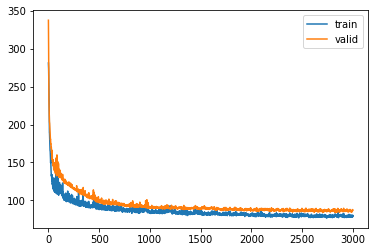

In [42]:
history = model.fit(train_1, labels_1, nb_epoch=3000, batch_size=256,validation_data=(test_1, test_labels_1), verbose=2,shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

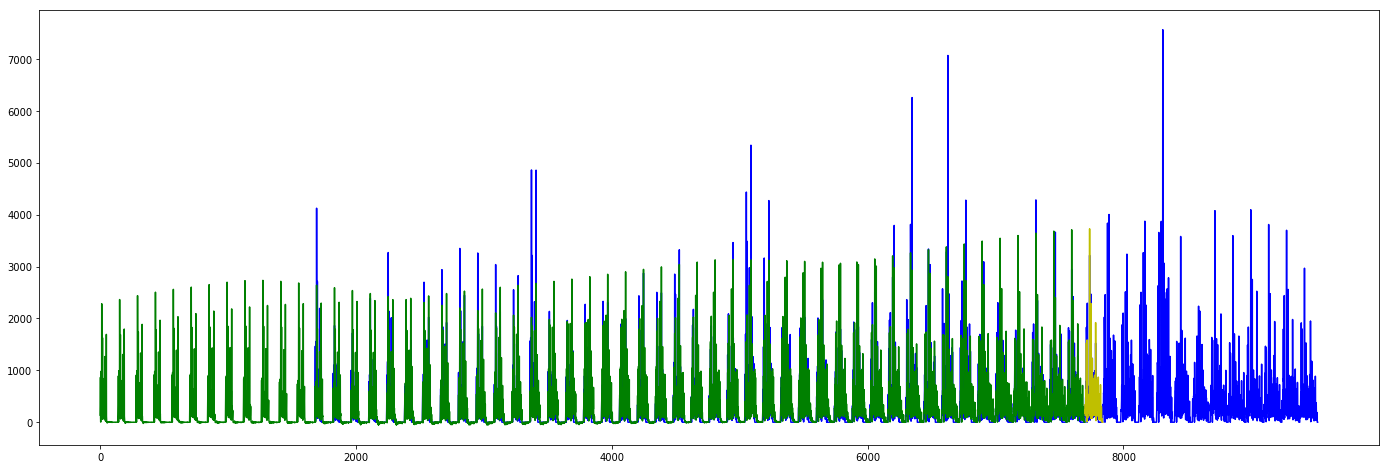

In [43]:
plt.figure(figsize=(24,8))
train_predict = model.predict(train_1)
valid_predict = model.predict(test_1)
#test_predict = model.predict(test_X)
plt.plot(labels[:-420], c='b')
plt.plot([x for x in train_predict], c='g')
plt.plot([None for _ in train_predict] + [x for x in valid_predict], c='y')
#plt.plot([None for _ in train_predict] + [None for _ in valid_predict] + [x for x in test_predict], c='r')
plt.show()

In [44]:
model.save('my_model_08.h5')   # HDF5 file, you have to pip3 install h5py if don't have it

In [50]:
pred_test_labels_1=model.predict(test_1)

In [51]:
math.sqrt(((pred_test_labels_1 - test_labels_1)**2).mean())

618.6493325352639

In [60]:
pred=pred_test_labels_1.reshape(-1,)#这里被坑了好久，一直没有注意数据结构

In [59]:
test_labels_1.shape

(140,)

In [61]:
math.sqrt(((pred - test_labels_1)**2).mean())

143.89257342230042

In [72]:
model2 = Sequential()
# model.add(LSTM(
#     batch_input_shape=(BATCH_SIZE, TIME_STEPS, INPUT_SIZE),       # Or: input_dim=INPUT_SIZE, input_length=TIME_STEPS,
#     output_dim=CELL_SIZE,
#     return_sequences=True,      # True: output at all steps. False: output as last step.
#     stateful=True,              # True: the final state of batch1 is feed into the initial state of batch2
# ))
model2.add(LSTM(64, input_shape=(train_2.shape[1],train_2.shape[2])))
model2.add(Dropout(.1))
model2.add(Dense(64))
model2.add(Dropout(.2))
model2.add(Dense(16))
model2.add(Dropout(.2))
model2.add(Dense(1))
model2.compile(loss = rmse_loss, optimizer='adam', metrics=['mse'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                52736     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_15 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total para

In [73]:
history2 = model2.fit(train_2, labels_2, nb_epoch=5000, batch_size=256,validation_data=(test_2, test_labels_2), verbose=2,shuffle=False)
# plot history
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='valid')
plt.legend()
plt.show()

Train on 7840 samples, validate on 140 samples
Epoch 1/5000
 - 2s - loss: 282.1769 - mean_squared_error: 328488.7276 - val_loss: 396.8295 - val_mean_squared_error: 372698.5625
Epoch 2/5000
 - 0s - loss: 279.2500 - mean_squared_error: 323284.9032 - val_loss: 380.6632 - val_mean_squared_error: 360034.0625
Epoch 3/5000
 - 0s - loss: 272.4385 - mean_squared_error: 311925.6266 - val_loss: 344.7622 - val_mean_squared_error: 332485.7812
Epoch 4/5000
 - 0s - loss: 261.6647 - mean_squared_error: 293558.2890 - val_loss: 297.7823 - val_mean_squared_error: 294336.5625
Epoch 5/5000
 - 0s - loss: 251.3964 - mean_squared_error: 279448.5890 - val_loss: 266.6590 - val_mean_squared_error: 259009.5469
Epoch 6/5000
 - 0s - loss: 240.8790 - mean_squared_error: 264756.9010 - val_loss: 251.6542 - val_mean_squared_error: 238091.7500
Epoch 7/5000
 - 0s - loss: 230.7947 - mean_squared_error: 249994.4655 - val_loss: 242.2689 - val_mean_squared_error: 222417.7812
Epoch 8/5000
 - 0s - loss: 219.3409 - mean_squared

Epoch 65/5000
 - 0s - loss: 115.9245 - mean_squared_error: 65228.0264 - val_loss: 151.3324 - val_mean_squared_error: 72303.9609
Epoch 66/5000
 - 0s - loss: 115.4050 - mean_squared_error: 69014.6648 - val_loss: 152.2050 - val_mean_squared_error: 71908.5156
Epoch 67/5000
 - 0s - loss: 112.7369 - mean_squared_error: 67030.4821 - val_loss: 151.3176 - val_mean_squared_error: 71337.6797
Epoch 68/5000
 - 0s - loss: 111.8145 - mean_squared_error: 64888.4902 - val_loss: 149.8288 - val_mean_squared_error: 70133.5625
Epoch 69/5000
 - 0s - loss: 113.4039 - mean_squared_error: 66377.5966 - val_loss: 150.3182 - val_mean_squared_error: 70444.4609
Epoch 70/5000
 - 0s - loss: 112.7622 - mean_squared_error: 65729.0882 - val_loss: 150.9686 - val_mean_squared_error: 70003.7031
Epoch 71/5000
 - 0s - loss: 111.2036 - mean_squared_error: 66059.0391 - val_loss: 154.4036 - val_mean_squared_error: 72123.7969
Epoch 72/5000
 - 0s - loss: 110.7014 - mean_squared_error: 65777.0462 - val_loss: 155.8822 - val_mean_sq

Epoch 129/5000
 - 0s - loss: 106.2855 - mean_squared_error: 58224.2179 - val_loss: 132.0450 - val_mean_squared_error: 51188.3672
Epoch 130/5000
 - 0s - loss: 105.8699 - mean_squared_error: 59225.8369 - val_loss: 131.4628 - val_mean_squared_error: 51185.1797
Epoch 131/5000
 - 0s - loss: 105.6031 - mean_squared_error: 56194.3883 - val_loss: 134.3514 - val_mean_squared_error: 52498.2266
Epoch 132/5000
 - 0s - loss: 106.3160 - mean_squared_error: 56802.0319 - val_loss: 135.8831 - val_mean_squared_error: 52579.9219
Epoch 133/5000
 - 0s - loss: 104.6573 - mean_squared_error: 57798.4941 - val_loss: 134.8144 - val_mean_squared_error: 51435.4805
Epoch 134/5000
 - 0s - loss: 103.2366 - mean_squared_error: 56985.9728 - val_loss: 134.2269 - val_mean_squared_error: 51579.9805
Epoch 135/5000
 - 0s - loss: 104.3163 - mean_squared_error: 59141.0881 - val_loss: 134.8118 - val_mean_squared_error: 52356.7227
Epoch 136/5000
 - 0s - loss: 107.4384 - mean_squared_error: 58304.1041 - val_loss: 131.3183 - val

Epoch 193/5000
 - 0s - loss: 105.3343 - mean_squared_error: 55326.7631 - val_loss: 126.2091 - val_mean_squared_error: 43069.0547
Epoch 194/5000
 - 0s - loss: 99.1825 - mean_squared_error: 52769.6195 - val_loss: 129.1737 - val_mean_squared_error: 43562.4141
Epoch 195/5000
 - 0s - loss: 99.1280 - mean_squared_error: 52148.6714 - val_loss: 122.5268 - val_mean_squared_error: 41816.3594
Epoch 196/5000
 - 0s - loss: 98.5150 - mean_squared_error: 53964.5309 - val_loss: 127.6801 - val_mean_squared_error: 42953.0000
Epoch 197/5000
 - 0s - loss: 102.2094 - mean_squared_error: 54582.2413 - val_loss: 131.5125 - val_mean_squared_error: 44780.5586
Epoch 198/5000
 - 0s - loss: 104.8068 - mean_squared_error: 53276.8097 - val_loss: 122.1019 - val_mean_squared_error: 40973.1445
Epoch 199/5000
 - 0s - loss: 98.7646 - mean_squared_error: 53166.7347 - val_loss: 126.9909 - val_mean_squared_error: 42689.7656
Epoch 200/5000
 - 0s - loss: 100.0018 - mean_squared_error: 53297.3971 - val_loss: 131.0093 - val_mea

Epoch 257/5000
 - 0s - loss: 96.7281 - mean_squared_error: 53405.4045 - val_loss: 121.9577 - val_mean_squared_error: 37874.3125
Epoch 258/5000
 - 0s - loss: 96.8950 - mean_squared_error: 51607.2003 - val_loss: 122.2896 - val_mean_squared_error: 37949.5430
Epoch 259/5000
 - 0s - loss: 97.5590 - mean_squared_error: 53076.6330 - val_loss: 119.4774 - val_mean_squared_error: 36799.8242
Epoch 260/5000
 - 0s - loss: 96.5220 - mean_squared_error: 52189.6146 - val_loss: 115.4771 - val_mean_squared_error: 35337.2578
Epoch 261/5000
 - 0s - loss: 98.1749 - mean_squared_error: 52134.2360 - val_loss: 117.5662 - val_mean_squared_error: 36716.3398
Epoch 262/5000
 - 0s - loss: 94.9067 - mean_squared_error: 49952.9873 - val_loss: 122.0745 - val_mean_squared_error: 37769.2188
Epoch 263/5000
 - 0s - loss: 96.1672 - mean_squared_error: 51786.4977 - val_loss: 121.5301 - val_mean_squared_error: 38007.0312
Epoch 264/5000
 - 0s - loss: 96.6236 - mean_squared_error: 50424.9950 - val_loss: 120.1869 - val_mean_sq

 - 0s - loss: 95.5275 - mean_squared_error: 50032.6859 - val_loss: 120.5540 - val_mean_squared_error: 33975.3047
Epoch 322/5000
 - 0s - loss: 95.0055 - mean_squared_error: 47199.4958 - val_loss: 113.3880 - val_mean_squared_error: 31428.2148
Epoch 323/5000
 - 0s - loss: 93.9725 - mean_squared_error: 48694.4236 - val_loss: 121.2609 - val_mean_squared_error: 33387.0000
Epoch 324/5000
 - 0s - loss: 93.5956 - mean_squared_error: 48243.1262 - val_loss: 118.4613 - val_mean_squared_error: 32604.9258
Epoch 325/5000
 - 0s - loss: 94.0814 - mean_squared_error: 50101.7793 - val_loss: 117.3218 - val_mean_squared_error: 31721.8711
Epoch 326/5000
 - 0s - loss: 94.1107 - mean_squared_error: 48286.8866 - val_loss: 114.0388 - val_mean_squared_error: 31381.8496
Epoch 327/5000
 - 0s - loss: 94.4304 - mean_squared_error: 48283.7194 - val_loss: 113.4984 - val_mean_squared_error: 31003.5039
Epoch 328/5000
 - 0s - loss: 93.7954 - mean_squared_error: 49064.7933 - val_loss: 118.6188 - val_mean_squared_error: 32

Epoch 386/5000
 - 0s - loss: 94.7185 - mean_squared_error: 48434.8198 - val_loss: 115.2321 - val_mean_squared_error: 30094.8965
Epoch 387/5000
 - 0s - loss: 93.2463 - mean_squared_error: 47980.7413 - val_loss: 109.5767 - val_mean_squared_error: 28397.5508
Epoch 388/5000
 - 0s - loss: 93.6188 - mean_squared_error: 47115.5314 - val_loss: 110.2183 - val_mean_squared_error: 28254.2441
Epoch 389/5000
 - 0s - loss: 92.9145 - mean_squared_error: 48711.6428 - val_loss: 106.5827 - val_mean_squared_error: 27689.8125
Epoch 390/5000
 - 0s - loss: 92.4531 - mean_squared_error: 47362.2841 - val_loss: 108.6470 - val_mean_squared_error: 28533.8496
Epoch 391/5000
 - 0s - loss: 94.0799 - mean_squared_error: 49439.9209 - val_loss: 107.4244 - val_mean_squared_error: 27884.8711
Epoch 392/5000
 - 0s - loss: 92.6706 - mean_squared_error: 48538.9716 - val_loss: 109.8168 - val_mean_squared_error: 28188.7852
Epoch 393/5000
 - 0s - loss: 93.9685 - mean_squared_error: 47485.7102 - val_loss: 107.8635 - val_mean_sq

Epoch 450/5000
 - 0s - loss: 96.0680 - mean_squared_error: 49800.9173 - val_loss: 110.0909 - val_mean_squared_error: 31923.1289
Epoch 451/5000
 - 0s - loss: 95.7438 - mean_squared_error: 47693.7961 - val_loss: 111.0543 - val_mean_squared_error: 32697.9746
Epoch 452/5000
 - 0s - loss: 94.2839 - mean_squared_error: 45438.1947 - val_loss: 110.4599 - val_mean_squared_error: 32098.5000
Epoch 453/5000
 - 0s - loss: 95.1541 - mean_squared_error: 48607.5665 - val_loss: 109.7438 - val_mean_squared_error: 31964.8652
Epoch 454/5000
 - 0s - loss: 94.2868 - mean_squared_error: 46510.0504 - val_loss: 113.2628 - val_mean_squared_error: 33304.6992
Epoch 455/5000
 - 0s - loss: 96.0141 - mean_squared_error: 50959.4148 - val_loss: 111.8770 - val_mean_squared_error: 32794.6719
Epoch 456/5000
 - 0s - loss: 94.0850 - mean_squared_error: 48612.9757 - val_loss: 110.0633 - val_mean_squared_error: 31823.3496
Epoch 457/5000
 - 0s - loss: 95.1635 - mean_squared_error: 49493.8015 - val_loss: 108.6119 - val_mean_sq

 - 0s - loss: 90.3805 - mean_squared_error: 47511.0101 - val_loss: 100.5443 - val_mean_squared_error: 25345.2188
Epoch 515/5000
 - 0s - loss: 89.6346 - mean_squared_error: 46457.9731 - val_loss: 103.1895 - val_mean_squared_error: 26215.5078
Epoch 516/5000
 - 0s - loss: 90.0048 - mean_squared_error: 46564.5273 - val_loss: 104.5859 - val_mean_squared_error: 27537.6758
Epoch 517/5000
 - 0s - loss: 90.0132 - mean_squared_error: 45860.0049 - val_loss: 102.0977 - val_mean_squared_error: 26173.0117
Epoch 518/5000
 - 0s - loss: 89.6267 - mean_squared_error: 48167.0459 - val_loss: 101.6001 - val_mean_squared_error: 25825.8184
Epoch 519/5000
 - 0s - loss: 90.8135 - mean_squared_error: 47279.8888 - val_loss: 99.2422 - val_mean_squared_error: 25284.8438
Epoch 520/5000
 - 0s - loss: 87.7571 - mean_squared_error: 43440.3281 - val_loss: 100.8928 - val_mean_squared_error: 25754.8105
Epoch 521/5000
 - 0s - loss: 90.8722 - mean_squared_error: 49620.6532 - val_loss: 103.3570 - val_mean_squared_error: 271

Epoch 579/5000
 - 0s - loss: 89.6273 - mean_squared_error: 46338.1311 - val_loss: 96.2657 - val_mean_squared_error: 24215.4707
Epoch 580/5000
 - 0s - loss: 89.5581 - mean_squared_error: 49502.0974 - val_loss: 96.7405 - val_mean_squared_error: 24743.2695
Epoch 581/5000
 - 0s - loss: 89.8360 - mean_squared_error: 47463.5569 - val_loss: 96.8755 - val_mean_squared_error: 24759.7812
Epoch 582/5000
 - 0s - loss: 88.8579 - mean_squared_error: 46368.7187 - val_loss: 96.8190 - val_mean_squared_error: 24795.8574
Epoch 583/5000
 - 0s - loss: 88.0635 - mean_squared_error: 45429.9889 - val_loss: 97.3676 - val_mean_squared_error: 25338.4570
Epoch 584/5000
 - 0s - loss: 89.8100 - mean_squared_error: 46514.2537 - val_loss: 96.2380 - val_mean_squared_error: 24048.3750
Epoch 585/5000
 - 0s - loss: 90.5115 - mean_squared_error: 47562.4958 - val_loss: 96.4080 - val_mean_squared_error: 24813.8105
Epoch 586/5000
 - 0s - loss: 90.0531 - mean_squared_error: 46816.4084 - val_loss: 98.2578 - val_mean_squared_er

Epoch 644/5000
 - 0s - loss: 93.9445 - mean_squared_error: 49029.0251 - val_loss: 113.9750 - val_mean_squared_error: 30324.4434
Epoch 645/5000
 - 0s - loss: 93.4439 - mean_squared_error: 48701.9065 - val_loss: 113.1796 - val_mean_squared_error: 30007.5293
Epoch 646/5000
 - 0s - loss: 92.9081 - mean_squared_error: 45288.8049 - val_loss: 113.1260 - val_mean_squared_error: 29646.6270
Epoch 647/5000
 - 0s - loss: 90.8481 - mean_squared_error: 44246.2871 - val_loss: 113.5560 - val_mean_squared_error: 29916.2383
Epoch 648/5000
 - 0s - loss: 92.9187 - mean_squared_error: 48068.5049 - val_loss: 112.7438 - val_mean_squared_error: 29998.4434
Epoch 649/5000
 - 0s - loss: 92.5052 - mean_squared_error: 45834.3865 - val_loss: 113.5849 - val_mean_squared_error: 29788.4102
Epoch 650/5000
 - 0s - loss: 89.2701 - mean_squared_error: 48182.0703 - val_loss: 109.6888 - val_mean_squared_error: 28919.7578
Epoch 651/5000
 - 0s - loss: 90.2247 - mean_squared_error: 47611.3999 - val_loss: 108.1684 - val_mean_sq

 - 0s - loss: 86.9145 - mean_squared_error: 45666.2425 - val_loss: 104.4863 - val_mean_squared_error: 26828.2168
Epoch 709/5000
 - 0s - loss: 87.3436 - mean_squared_error: 45352.1197 - val_loss: 104.7938 - val_mean_squared_error: 27106.3789
Epoch 710/5000
 - 0s - loss: 86.2207 - mean_squared_error: 44320.0642 - val_loss: 100.2177 - val_mean_squared_error: 25891.3984
Epoch 711/5000
 - 0s - loss: 86.9863 - mean_squared_error: 46340.2324 - val_loss: 103.8545 - val_mean_squared_error: 26590.5059
Epoch 712/5000
 - 0s - loss: 87.7979 - mean_squared_error: 47414.7497 - val_loss: 102.0665 - val_mean_squared_error: 25795.5293
Epoch 713/5000
 - 0s - loss: 87.3524 - mean_squared_error: 44371.4334 - val_loss: 103.0756 - val_mean_squared_error: 26449.3184
Epoch 714/5000
 - 0s - loss: 87.3185 - mean_squared_error: 45988.2590 - val_loss: 104.8605 - val_mean_squared_error: 26963.4395
Epoch 715/5000
 - 0s - loss: 87.0534 - mean_squared_error: 44331.3710 - val_loss: 101.8398 - val_mean_squared_error: 25

Epoch 773/5000
 - 0s - loss: 86.7512 - mean_squared_error: 46522.0801 - val_loss: 102.2030 - val_mean_squared_error: 25915.6152
Epoch 774/5000
 - 0s - loss: 86.7302 - mean_squared_error: 47382.8124 - val_loss: 102.6660 - val_mean_squared_error: 26197.5527
Epoch 775/5000
 - 0s - loss: 87.7351 - mean_squared_error: 45724.6674 - val_loss: 102.4949 - val_mean_squared_error: 25978.8887
Epoch 776/5000
 - 0s - loss: 86.8327 - mean_squared_error: 48450.2871 - val_loss: 102.3666 - val_mean_squared_error: 26025.7129
Epoch 777/5000
 - 0s - loss: 86.8147 - mean_squared_error: 45521.0532 - val_loss: 102.3364 - val_mean_squared_error: 25561.7539
Epoch 778/5000
 - 0s - loss: 87.3244 - mean_squared_error: 45670.4876 - val_loss: 102.7305 - val_mean_squared_error: 26027.1992
Epoch 779/5000
 - 0s - loss: 87.3471 - mean_squared_error: 46845.2091 - val_loss: 97.6074 - val_mean_squared_error: 24798.7168
Epoch 780/5000
 - 0s - loss: 86.5501 - mean_squared_error: 44752.9261 - val_loss: 102.2453 - val_mean_squ

Epoch 838/5000
 - 0s - loss: 86.5182 - mean_squared_error: 44982.0401 - val_loss: 96.6836 - val_mean_squared_error: 23980.0273
Epoch 839/5000
 - 0s - loss: 86.7093 - mean_squared_error: 45979.4066 - val_loss: 98.6813 - val_mean_squared_error: 24547.5293
Epoch 840/5000
 - 0s - loss: 87.1486 - mean_squared_error: 45396.5710 - val_loss: 96.3832 - val_mean_squared_error: 24125.7539
Epoch 841/5000
 - 0s - loss: 87.5868 - mean_squared_error: 48166.4461 - val_loss: 95.5320 - val_mean_squared_error: 23496.9434
Epoch 842/5000
 - 0s - loss: 86.5480 - mean_squared_error: 44514.0798 - val_loss: 95.5586 - val_mean_squared_error: 23066.7031
Epoch 843/5000
 - 0s - loss: 87.5196 - mean_squared_error: 46270.3070 - val_loss: 96.5370 - val_mean_squared_error: 23947.9062
Epoch 844/5000
 - 0s - loss: 87.7663 - mean_squared_error: 48678.9215 - val_loss: 96.6589 - val_mean_squared_error: 24012.5176
Epoch 845/5000
 - 0s - loss: 87.7388 - mean_squared_error: 45487.0546 - val_loss: 93.3510 - val_mean_squared_er

Epoch 903/5000
 - 0s - loss: 85.6975 - mean_squared_error: 46594.1597 - val_loss: 95.7228 - val_mean_squared_error: 24641.5957
Epoch 904/5000
 - 0s - loss: 86.4666 - mean_squared_error: 45111.7533 - val_loss: 100.4270 - val_mean_squared_error: 26194.3965
Epoch 905/5000
 - 0s - loss: 86.0154 - mean_squared_error: 44110.9191 - val_loss: 104.2097 - val_mean_squared_error: 27095.4824
Epoch 906/5000
 - 0s - loss: 86.0258 - mean_squared_error: 46585.6604 - val_loss: 101.7940 - val_mean_squared_error: 26655.2402
Epoch 907/5000
 - 0s - loss: 86.5610 - mean_squared_error: 43762.3833 - val_loss: 104.1947 - val_mean_squared_error: 27395.0508
Epoch 908/5000
 - 0s - loss: 85.6608 - mean_squared_error: 45494.9831 - val_loss: 101.2558 - val_mean_squared_error: 26610.1992
Epoch 909/5000
 - 0s - loss: 85.5893 - mean_squared_error: 45211.5902 - val_loss: 100.5823 - val_mean_squared_error: 26323.6016
Epoch 910/5000
 - 0s - loss: 85.5151 - mean_squared_error: 45185.6691 - val_loss: 103.1341 - val_mean_squ

Epoch 968/5000
 - 0s - loss: 86.9508 - mean_squared_error: 48392.3550 - val_loss: 97.2990 - val_mean_squared_error: 24603.1367
Epoch 969/5000
 - 0s - loss: 84.7615 - mean_squared_error: 44052.6888 - val_loss: 98.5694 - val_mean_squared_error: 25166.8145
Epoch 970/5000
 - 0s - loss: 84.7591 - mean_squared_error: 45398.9268 - val_loss: 94.8283 - val_mean_squared_error: 23679.3789
Epoch 971/5000
 - 0s - loss: 84.4772 - mean_squared_error: 44633.3562 - val_loss: 96.2666 - val_mean_squared_error: 24177.8809
Epoch 972/5000
 - 0s - loss: 85.1390 - mean_squared_error: 47368.1873 - val_loss: 98.6498 - val_mean_squared_error: 25015.0137
Epoch 973/5000
 - 0s - loss: 84.6463 - mean_squared_error: 45629.3315 - val_loss: 96.9182 - val_mean_squared_error: 24372.9570
Epoch 974/5000
 - 0s - loss: 85.0538 - mean_squared_error: 45100.7018 - val_loss: 94.5733 - val_mean_squared_error: 23372.9004
Epoch 975/5000
 - 0s - loss: 83.4841 - mean_squared_error: 42697.7569 - val_loss: 97.5591 - val_mean_squared_er

Epoch 1033/5000
 - 0s - loss: 85.5873 - mean_squared_error: 46299.1126 - val_loss: 101.1982 - val_mean_squared_error: 26016.5938
Epoch 1034/5000
 - 0s - loss: 85.2657 - mean_squared_error: 45524.6474 - val_loss: 100.2379 - val_mean_squared_error: 25380.7246
Epoch 1035/5000
 - 0s - loss: 84.2806 - mean_squared_error: 44546.6725 - val_loss: 98.5178 - val_mean_squared_error: 25334.2227
Epoch 1036/5000
 - 0s - loss: 85.1308 - mean_squared_error: 46053.4501 - val_loss: 97.1919 - val_mean_squared_error: 24489.3789
Epoch 1037/5000
 - 0s - loss: 84.9594 - mean_squared_error: 44798.8025 - val_loss: 99.6343 - val_mean_squared_error: 25534.7578
Epoch 1038/5000
 - 0s - loss: 84.2981 - mean_squared_error: 44074.3570 - val_loss: 95.9757 - val_mean_squared_error: 24035.4473
Epoch 1039/5000
 - 0s - loss: 86.0291 - mean_squared_error: 46360.2170 - val_loss: 97.0574 - val_mean_squared_error: 24512.3145
Epoch 1040/5000
 - 0s - loss: 83.5896 - mean_squared_error: 42006.2449 - val_loss: 98.0774 - val_mean_

Epoch 1097/5000
 - 0s - loss: 82.9083 - mean_squared_error: 43169.9002 - val_loss: 105.5913 - val_mean_squared_error: 26523.6602
Epoch 1098/5000
 - 0s - loss: 83.8261 - mean_squared_error: 44126.4971 - val_loss: 101.1892 - val_mean_squared_error: 25289.0742
Epoch 1099/5000
 - 0s - loss: 83.2290 - mean_squared_error: 43209.3649 - val_loss: 101.2032 - val_mean_squared_error: 25617.5410
Epoch 1100/5000
 - 0s - loss: 84.7902 - mean_squared_error: 43825.7103 - val_loss: 103.7920 - val_mean_squared_error: 25976.9199
Epoch 1101/5000
 - 0s - loss: 85.0430 - mean_squared_error: 45640.7535 - val_loss: 101.0164 - val_mean_squared_error: 25580.6602
Epoch 1102/5000
 - 0s - loss: 84.4710 - mean_squared_error: 45350.8417 - val_loss: 103.6831 - val_mean_squared_error: 25973.6348
Epoch 1103/5000
 - 0s - loss: 85.3044 - mean_squared_error: 47679.7407 - val_loss: 105.2251 - val_mean_squared_error: 26074.5820
Epoch 1104/5000
 - 0s - loss: 84.4493 - mean_squared_error: 45664.0035 - val_loss: 104.0599 - val

Epoch 1161/5000
 - 0s - loss: 84.5907 - mean_squared_error: 45962.9127 - val_loss: 99.6533 - val_mean_squared_error: 23835.2500
Epoch 1162/5000
 - 0s - loss: 84.9866 - mean_squared_error: 47433.5480 - val_loss: 97.4958 - val_mean_squared_error: 23037.0605
Epoch 1163/5000
 - 0s - loss: 84.2373 - mean_squared_error: 47014.8253 - val_loss: 95.6416 - val_mean_squared_error: 22796.6289
Epoch 1164/5000
 - 0s - loss: 84.6192 - mean_squared_error: 44413.3746 - val_loss: 98.2796 - val_mean_squared_error: 23002.8887
Epoch 1165/5000
 - 0s - loss: 83.8979 - mean_squared_error: 45460.8342 - val_loss: 95.5956 - val_mean_squared_error: 22440.3047
Epoch 1166/5000
 - 0s - loss: 83.8652 - mean_squared_error: 45427.6568 - val_loss: 94.1864 - val_mean_squared_error: 22318.6230
Epoch 1167/5000
 - 0s - loss: 85.1461 - mean_squared_error: 46615.6105 - val_loss: 96.3941 - val_mean_squared_error: 22838.5215
Epoch 1168/5000
 - 0s - loss: 82.7873 - mean_squared_error: 43798.5293 - val_loss: 94.7045 - val_mean_sq

Epoch 1225/5000
 - 0s - loss: 83.9520 - mean_squared_error: 43548.6249 - val_loss: 103.1052 - val_mean_squared_error: 25389.7715
Epoch 1226/5000
 - 0s - loss: 84.2307 - mean_squared_error: 47365.6122 - val_loss: 101.3836 - val_mean_squared_error: 25015.9863
Epoch 1227/5000
 - 0s - loss: 84.7499 - mean_squared_error: 44522.5535 - val_loss: 105.8846 - val_mean_squared_error: 26226.1719
Epoch 1228/5000
 - 0s - loss: 84.2626 - mean_squared_error: 45149.9989 - val_loss: 100.1121 - val_mean_squared_error: 24233.9238
Epoch 1229/5000
 - 0s - loss: 83.0145 - mean_squared_error: 45449.3642 - val_loss: 99.0352 - val_mean_squared_error: 23886.4941
Epoch 1230/5000
 - 0s - loss: 83.9511 - mean_squared_error: 43979.0453 - val_loss: 99.4454 - val_mean_squared_error: 24482.0742
Epoch 1231/5000
 - 0s - loss: 85.6861 - mean_squared_error: 46429.4759 - val_loss: 97.8789 - val_mean_squared_error: 23842.9473
Epoch 1232/5000
 - 0s - loss: 84.2291 - mean_squared_error: 46431.1961 - val_loss: 96.2688 - val_mea

Epoch 1289/5000
 - 0s - loss: 84.0101 - mean_squared_error: 44444.3708 - val_loss: 98.3166 - val_mean_squared_error: 23618.5898
Epoch 1290/5000
 - 0s - loss: 82.0252 - mean_squared_error: 44221.2845 - val_loss: 96.9630 - val_mean_squared_error: 23149.7598
Epoch 1291/5000
 - 0s - loss: 83.3136 - mean_squared_error: 44255.3685 - val_loss: 96.0114 - val_mean_squared_error: 22687.0000
Epoch 1292/5000
 - 0s - loss: 82.5484 - mean_squared_error: 43330.8683 - val_loss: 97.8520 - val_mean_squared_error: 23719.3711
Epoch 1293/5000
 - 0s - loss: 82.8485 - mean_squared_error: 43848.2769 - val_loss: 98.5275 - val_mean_squared_error: 23674.5352
Epoch 1294/5000
 - 0s - loss: 84.2082 - mean_squared_error: 45357.2631 - val_loss: 94.5481 - val_mean_squared_error: 22476.3965
Epoch 1295/5000
 - 0s - loss: 82.4919 - mean_squared_error: 44163.6054 - val_loss: 95.4390 - val_mean_squared_error: 22699.8887
Epoch 1296/5000
 - 0s - loss: 81.9817 - mean_squared_error: 42575.9882 - val_loss: 98.3762 - val_mean_sq

Epoch 1353/5000
 - 0s - loss: 82.9139 - mean_squared_error: 44010.7243 - val_loss: 94.9706 - val_mean_squared_error: 22569.6289
Epoch 1354/5000
 - 0s - loss: 83.5777 - mean_squared_error: 43499.2439 - val_loss: 94.2504 - val_mean_squared_error: 22005.3223
Epoch 1355/5000
 - 0s - loss: 83.0853 - mean_squared_error: 43709.9742 - val_loss: 96.9272 - val_mean_squared_error: 22718.0156
Epoch 1356/5000
 - 0s - loss: 82.6379 - mean_squared_error: 45622.4504 - val_loss: 93.3001 - val_mean_squared_error: 21678.2598
Epoch 1357/5000
 - 0s - loss: 83.3432 - mean_squared_error: 43251.5676 - val_loss: 96.8969 - val_mean_squared_error: 23000.4395
Epoch 1358/5000
 - 0s - loss: 81.7967 - mean_squared_error: 44296.1654 - val_loss: 98.2679 - val_mean_squared_error: 23497.5195
Epoch 1359/5000
 - 0s - loss: 81.6920 - mean_squared_error: 42186.3737 - val_loss: 94.2880 - val_mean_squared_error: 22135.7852
Epoch 1360/5000
 - 0s - loss: 84.0003 - mean_squared_error: 44661.5941 - val_loss: 94.7133 - val_mean_sq

Epoch 1417/5000
 - 0s - loss: 82.4679 - mean_squared_error: 44521.1011 - val_loss: 97.0257 - val_mean_squared_error: 22444.5664
Epoch 1418/5000
 - 0s - loss: 81.5915 - mean_squared_error: 43051.0235 - val_loss: 96.5979 - val_mean_squared_error: 22132.7285
Epoch 1419/5000
 - 0s - loss: 81.5228 - mean_squared_error: 43884.9042 - val_loss: 97.0617 - val_mean_squared_error: 22399.4746
Epoch 1420/5000
 - 0s - loss: 82.6037 - mean_squared_error: 45698.5574 - val_loss: 99.4746 - val_mean_squared_error: 23716.2344
Epoch 1421/5000
 - 0s - loss: 82.1357 - mean_squared_error: 44081.3885 - val_loss: 99.1865 - val_mean_squared_error: 23268.0898
Epoch 1422/5000
 - 0s - loss: 82.5921 - mean_squared_error: 44751.6803 - val_loss: 97.4531 - val_mean_squared_error: 22583.7246
Epoch 1423/5000
 - 0s - loss: 83.1756 - mean_squared_error: 44698.0604 - val_loss: 98.9480 - val_mean_squared_error: 22967.1152
Epoch 1424/5000
 - 0s - loss: 80.8435 - mean_squared_error: 40542.2134 - val_loss: 97.1441 - val_mean_sq

Epoch 1481/5000
 - 0s - loss: 82.9515 - mean_squared_error: 43658.1931 - val_loss: 93.6471 - val_mean_squared_error: 21553.9531
Epoch 1482/5000
 - 0s - loss: 82.2453 - mean_squared_error: 42552.8912 - val_loss: 93.2820 - val_mean_squared_error: 21069.3848
Epoch 1483/5000
 - 0s - loss: 82.4219 - mean_squared_error: 43984.3613 - val_loss: 93.0506 - val_mean_squared_error: 21332.5098
Epoch 1484/5000
 - 0s - loss: 82.8531 - mean_squared_error: 46225.8364 - val_loss: 93.5550 - val_mean_squared_error: 21133.4570
Epoch 1485/5000
 - 0s - loss: 83.3312 - mean_squared_error: 45050.8583 - val_loss: 94.8778 - val_mean_squared_error: 21901.9102
Epoch 1486/5000
 - 0s - loss: 83.3051 - mean_squared_error: 44900.5168 - val_loss: 98.4582 - val_mean_squared_error: 23517.6504
Epoch 1487/5000
 - 0s - loss: 83.2350 - mean_squared_error: 44079.5082 - val_loss: 93.7976 - val_mean_squared_error: 22118.6816
Epoch 1488/5000
 - 0s - loss: 81.6395 - mean_squared_error: 42724.3681 - val_loss: 95.9069 - val_mean_sq

Epoch 1545/5000
 - 0s - loss: 83.7008 - mean_squared_error: 45828.3160 - val_loss: 101.7547 - val_mean_squared_error: 24714.8438
Epoch 1546/5000
 - 0s - loss: 83.0201 - mean_squared_error: 47220.2070 - val_loss: 106.2527 - val_mean_squared_error: 26357.5137
Epoch 1547/5000
 - 0s - loss: 83.2840 - mean_squared_error: 44646.1319 - val_loss: 98.4401 - val_mean_squared_error: 23806.7012
Epoch 1548/5000
 - 0s - loss: 81.9180 - mean_squared_error: 43157.3144 - val_loss: 102.9349 - val_mean_squared_error: 24762.7188
Epoch 1549/5000
 - 0s - loss: 81.3706 - mean_squared_error: 42919.9926 - val_loss: 100.7400 - val_mean_squared_error: 24036.5391
Epoch 1550/5000
 - 0s - loss: 82.3879 - mean_squared_error: 43329.0062 - val_loss: 99.8156 - val_mean_squared_error: 23949.3789
Epoch 1551/5000
 - 0s - loss: 82.4115 - mean_squared_error: 44188.5441 - val_loss: 103.6206 - val_mean_squared_error: 24852.7402
Epoch 1552/5000
 - 0s - loss: 81.4431 - mean_squared_error: 42909.7329 - val_loss: 101.0969 - val_m

Epoch 1609/5000
 - 0s - loss: 82.0211 - mean_squared_error: 41780.2220 - val_loss: 91.7295 - val_mean_squared_error: 20838.8750
Epoch 1610/5000
 - 0s - loss: 83.4959 - mean_squared_error: 43801.1550 - val_loss: 93.2682 - val_mean_squared_error: 21948.5527
Epoch 1611/5000
 - 0s - loss: 83.7614 - mean_squared_error: 43084.3653 - val_loss: 94.7566 - val_mean_squared_error: 22347.1113
Epoch 1612/5000
 - 0s - loss: 85.8678 - mean_squared_error: 44952.8852 - val_loss: 95.7500 - val_mean_squared_error: 23539.1348
Epoch 1613/5000
 - 0s - loss: 83.9464 - mean_squared_error: 42970.8203 - val_loss: 101.3298 - val_mean_squared_error: 25871.5215
Epoch 1614/5000
 - 0s - loss: 83.7309 - mean_squared_error: 44053.3914 - val_loss: 102.5613 - val_mean_squared_error: 25699.5000
Epoch 1615/5000
 - 0s - loss: 83.3654 - mean_squared_error: 44723.3539 - val_loss: 101.7349 - val_mean_squared_error: 25461.7402
Epoch 1616/5000
 - 0s - loss: 83.6745 - mean_squared_error: 42712.4628 - val_loss: 95.5134 - val_mean

Epoch 1673/5000
 - 0s - loss: 81.9947 - mean_squared_error: 43501.8977 - val_loss: 96.4444 - val_mean_squared_error: 22143.5996
Epoch 1674/5000
 - 0s - loss: 82.8792 - mean_squared_error: 45273.4940 - val_loss: 99.1003 - val_mean_squared_error: 22882.7559
Epoch 1675/5000
 - 0s - loss: 81.7336 - mean_squared_error: 42322.2941 - val_loss: 98.8643 - val_mean_squared_error: 23125.0020
Epoch 1676/5000
 - 0s - loss: 81.1257 - mean_squared_error: 44240.0122 - val_loss: 97.8481 - val_mean_squared_error: 22605.6172
Epoch 1677/5000
 - 0s - loss: 82.7878 - mean_squared_error: 43473.4968 - val_loss: 96.4082 - val_mean_squared_error: 22233.0293
Epoch 1678/5000
 - 0s - loss: 81.1941 - mean_squared_error: 44333.5787 - val_loss: 92.4195 - val_mean_squared_error: 20743.1738
Epoch 1679/5000
 - 0s - loss: 80.4834 - mean_squared_error: 43148.6388 - val_loss: 95.7969 - val_mean_squared_error: 21871.1543
Epoch 1680/5000
 - 0s - loss: 80.1416 - mean_squared_error: 42063.4238 - val_loss: 98.5449 - val_mean_sq

Epoch 1737/5000
 - 0s - loss: 80.6014 - mean_squared_error: 43768.2859 - val_loss: 97.0249 - val_mean_squared_error: 21661.7402
Epoch 1738/5000
 - 0s - loss: 81.8436 - mean_squared_error: 45468.0096 - val_loss: 96.8648 - val_mean_squared_error: 22514.4570
Epoch 1739/5000
 - 0s - loss: 80.2385 - mean_squared_error: 44388.1848 - val_loss: 99.4130 - val_mean_squared_error: 23518.4941
Epoch 1740/5000
 - 0s - loss: 80.7202 - mean_squared_error: 44372.3716 - val_loss: 96.7432 - val_mean_squared_error: 21907.0215
Epoch 1741/5000
 - 0s - loss: 80.8516 - mean_squared_error: 41753.3561 - val_loss: 94.0763 - val_mean_squared_error: 21660.3926
Epoch 1742/5000
 - 0s - loss: 80.8583 - mean_squared_error: 42477.9287 - val_loss: 97.7567 - val_mean_squared_error: 22440.1582
Epoch 1743/5000
 - 0s - loss: 80.1545 - mean_squared_error: 40840.9525 - val_loss: 97.1977 - val_mean_squared_error: 22543.6152
Epoch 1744/5000
 - 0s - loss: 81.0333 - mean_squared_error: 42952.4176 - val_loss: 97.5162 - val_mean_sq

Epoch 1804/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1805/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1806/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1807/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1808/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1809/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1810/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1811/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1812/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1813/5000
 - 0s - loss: nan - mean_squar

Epoch 1882/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1883/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1884/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1885/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1886/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1887/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1888/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1889/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1890/5000
 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 1891/5000
 - 0s - loss: nan - mean_squar

KeyboardInterrupt: 

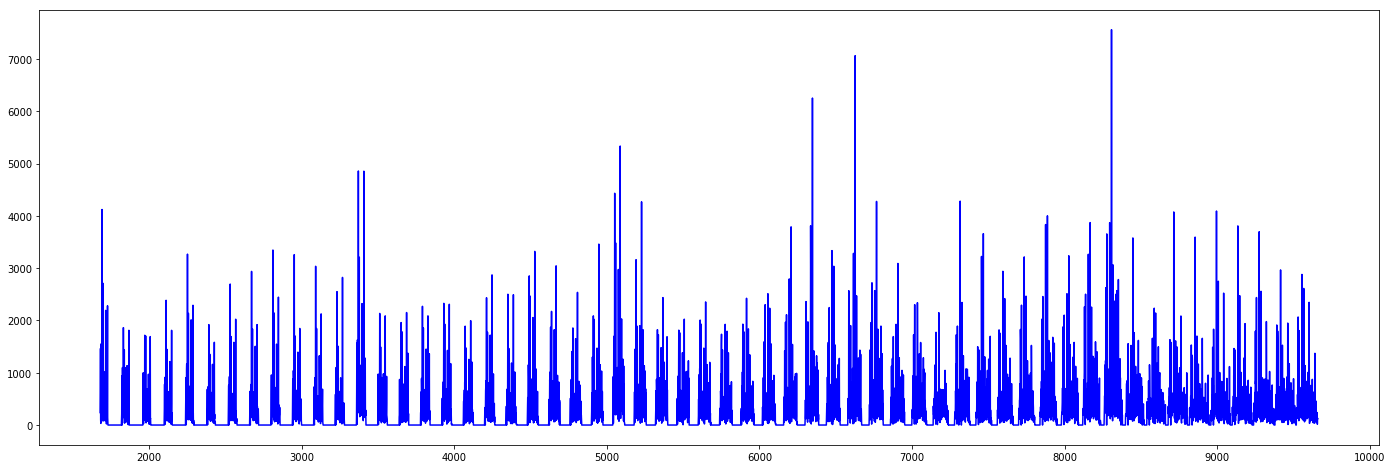

In [65]:
plt.figure(figsize=(24,8))
train_predict2 = model2.predict(train_2)
valid_predict2 = model2.predict(test_2)
#test_predict = model.predict(test_X)
plt.plot(labels[:-280], c='b')
plt.plot([x for x in train_predict2], c='g')
plt.plot([None for _ in train_predict2] + [x for x in valid_predict2], c='y')
#plt.plot([None for _ in train_predict] + [None for _ in valid_predict] + [x for x in test_predict], c='r')
plt.show()

In [66]:
pred_test_labels_2=model2.predict(test_2)
math.sqrt(((pred_test_labels_2.reshape(-1,) - test_labels_2)**2).mean())

nan

In [19]:
model3 = Sequential()
# model.add(LSTM(
#     batch_input_shape=(BATCH_SIZE, TIME_STEPS, INPUT_SIZE),       # Or: input_dim=INPUT_SIZE, input_length=TIME_STEPS,
#     output_dim=CELL_SIZE,
#     return_sequences=True,      # True: output at all steps. False: output as last step.
#     stateful=True,              # True: the final state of batch1 is feed into the initial state of batch2
# ))
model3.add(LSTM(64, input_shape=(train_3.shape[1],train_3.shape[2])))
model3.add(Dropout(.5))
model3.add(Dense(64))
model3.add(Dropout(.5))
model3.add(Dense(16))
model3.add(Dropout(.5))
model3.add(Dense(1))
model3.compile(loss ='mse', optimizer='adam', metrics=['mse'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                55040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total para

Train on 7980 samples, validate on 140 samples
Epoch 1/2000
 - 1s - loss: 327647.4919 - mean_squared_error: 327647.4919 - val_loss: 325066.4688 - val_mean_squared_error: 325066.4688
Epoch 2/2000
 - 0s - loss: 314913.4886 - mean_squared_error: 314913.4886 - val_loss: 294864.5312 - val_mean_squared_error: 294864.5312
Epoch 3/2000
 - 0s - loss: 278236.3486 - mean_squared_error: 278236.3486 - val_loss: 229676.4219 - val_mean_squared_error: 229676.4219
Epoch 4/2000
 - 0s - loss: 252213.6675 - mean_squared_error: 252213.6675 - val_loss: 207762.3750 - val_mean_squared_error: 207762.3750
Epoch 5/2000
 - 0s - loss: 252117.7298 - mean_squared_error: 252117.7298 - val_loss: 206596.4531 - val_mean_squared_error: 206596.4531
Epoch 6/2000
 - 0s - loss: 246190.1847 - mean_squared_error: 246190.1847 - val_loss: 201307.2344 - val_mean_squared_error: 201307.2344
Epoch 7/2000
 - 0s - loss: 235977.0141 - mean_squared_error: 235977.0141 - val_loss: 192176.7344 - val_mean_squared_error: 192176.7344
Epoch 8/

Epoch 63/2000
 - 0s - loss: 80757.6016 - mean_squared_error: 80757.6016 - val_loss: 52927.0039 - val_mean_squared_error: 52927.0039
Epoch 64/2000
 - 0s - loss: 79105.9872 - mean_squared_error: 79105.9872 - val_loss: 52725.7344 - val_mean_squared_error: 52725.7344
Epoch 65/2000
 - 0s - loss: 75522.2581 - mean_squared_error: 75522.2581 - val_loss: 53306.0234 - val_mean_squared_error: 53306.0234
Epoch 66/2000
 - 0s - loss: 80014.7153 - mean_squared_error: 80014.7153 - val_loss: 54730.2617 - val_mean_squared_error: 54730.2617
Epoch 67/2000
 - 0s - loss: 83271.1348 - mean_squared_error: 83271.1348 - val_loss: 51360.6914 - val_mean_squared_error: 51360.6914
Epoch 68/2000
 - 0s - loss: 75508.4568 - mean_squared_error: 75508.4568 - val_loss: 51037.7344 - val_mean_squared_error: 51037.7344
Epoch 69/2000
 - 0s - loss: 74997.6065 - mean_squared_error: 74997.6065 - val_loss: 50879.3203 - val_mean_squared_error: 50879.3203
Epoch 70/2000
 - 0s - loss: 78261.9492 - mean_squared_error: 78261.9492 - va

Epoch 125/2000
 - 0s - loss: 76731.6092 - mean_squared_error: 76731.6092 - val_loss: 36615.4805 - val_mean_squared_error: 36615.4805
Epoch 126/2000
 - 0s - loss: 68501.7076 - mean_squared_error: 68501.7076 - val_loss: 36206.3633 - val_mean_squared_error: 36206.3633
Epoch 127/2000
 - 0s - loss: 73594.7446 - mean_squared_error: 73594.7446 - val_loss: 37262.7344 - val_mean_squared_error: 37262.7344
Epoch 128/2000
 - 0s - loss: 71697.6833 - mean_squared_error: 71697.6833 - val_loss: 38486.7969 - val_mean_squared_error: 38486.7969
Epoch 129/2000
 - 0s - loss: 73965.7443 - mean_squared_error: 73965.7443 - val_loss: 37092.7305 - val_mean_squared_error: 37092.7305
Epoch 130/2000
 - 0s - loss: 71690.1047 - mean_squared_error: 71690.1047 - val_loss: 36064.6016 - val_mean_squared_error: 36064.6016
Epoch 131/2000
 - 0s - loss: 75340.6851 - mean_squared_error: 75340.6851 - val_loss: 36718.2891 - val_mean_squared_error: 36718.2891
Epoch 132/2000
 - 0s - loss: 70679.9474 - mean_squared_error: 70679.9

Epoch 187/2000
 - 0s - loss: 71877.8520 - mean_squared_error: 71877.8520 - val_loss: 33838.8477 - val_mean_squared_error: 33838.8477
Epoch 188/2000
 - 0s - loss: 71081.2298 - mean_squared_error: 71081.2298 - val_loss: 31456.6172 - val_mean_squared_error: 31456.6172
Epoch 189/2000
 - 0s - loss: 71383.2244 - mean_squared_error: 71383.2244 - val_loss: 32455.0078 - val_mean_squared_error: 32455.0078
Epoch 190/2000
 - 0s - loss: 73325.4426 - mean_squared_error: 73325.4426 - val_loss: 32710.2285 - val_mean_squared_error: 32710.2285
Epoch 191/2000
 - 0s - loss: 68137.2412 - mean_squared_error: 68137.2412 - val_loss: 31933.4902 - val_mean_squared_error: 31933.4902
Epoch 192/2000
 - 0s - loss: 67925.1254 - mean_squared_error: 67925.1254 - val_loss: 31801.8066 - val_mean_squared_error: 31801.8066
Epoch 193/2000
 - 0s - loss: 69996.0369 - mean_squared_error: 69996.0369 - val_loss: 31365.3145 - val_mean_squared_error: 31365.3145
Epoch 194/2000
 - 0s - loss: 72050.4548 - mean_squared_error: 72050.4

Epoch 249/2000
 - 0s - loss: 69081.8141 - mean_squared_error: 69081.8141 - val_loss: 30573.3066 - val_mean_squared_error: 30573.3066
Epoch 250/2000
 - 0s - loss: 66022.3784 - mean_squared_error: 66022.3784 - val_loss: 29970.5078 - val_mean_squared_error: 29970.5078
Epoch 251/2000
 - 0s - loss: 67283.6968 - mean_squared_error: 67283.6968 - val_loss: 31982.8027 - val_mean_squared_error: 31982.8027
Epoch 252/2000
 - 0s - loss: 66738.0998 - mean_squared_error: 66738.0998 - val_loss: 30492.7148 - val_mean_squared_error: 30492.7148
Epoch 253/2000
 - 0s - loss: 71416.6877 - mean_squared_error: 71416.6877 - val_loss: 28978.0508 - val_mean_squared_error: 28978.0508
Epoch 254/2000
 - 0s - loss: 67913.1923 - mean_squared_error: 67913.1923 - val_loss: 29966.9746 - val_mean_squared_error: 29966.9746
Epoch 255/2000
 - 0s - loss: 69549.1091 - mean_squared_error: 69549.1091 - val_loss: 31270.8652 - val_mean_squared_error: 31270.8652
Epoch 256/2000
 - 0s - loss: 68335.5209 - mean_squared_error: 68335.5

Epoch 311/2000
 - 0s - loss: 67042.5951 - mean_squared_error: 67042.5951 - val_loss: 29081.4902 - val_mean_squared_error: 29081.4902
Epoch 312/2000
 - 0s - loss: 63370.3451 - mean_squared_error: 63370.3451 - val_loss: 28739.2617 - val_mean_squared_error: 28739.2617
Epoch 313/2000
 - 0s - loss: 68111.0498 - mean_squared_error: 68111.0498 - val_loss: 30016.9219 - val_mean_squared_error: 30016.9219
Epoch 314/2000
 - 0s - loss: 67894.9581 - mean_squared_error: 67894.9581 - val_loss: 29394.7422 - val_mean_squared_error: 29394.7422
Epoch 315/2000
 - 0s - loss: 72064.7767 - mean_squared_error: 72064.7767 - val_loss: 28981.0293 - val_mean_squared_error: 28981.0293
Epoch 316/2000
 - 0s - loss: 68357.4679 - mean_squared_error: 68357.4679 - val_loss: 31236.8281 - val_mean_squared_error: 31236.8281
Epoch 317/2000
 - 0s - loss: 65010.1791 - mean_squared_error: 65010.1791 - val_loss: 30577.0723 - val_mean_squared_error: 30577.0723
Epoch 318/2000
 - 0s - loss: 66467.2651 - mean_squared_error: 66467.2

Epoch 373/2000
 - 0s - loss: 66319.1295 - mean_squared_error: 66319.1295 - val_loss: 27110.8711 - val_mean_squared_error: 27110.8711
Epoch 374/2000
 - 0s - loss: 68137.0397 - mean_squared_error: 68137.0397 - val_loss: 27165.5000 - val_mean_squared_error: 27165.5000
Epoch 375/2000
 - 0s - loss: 68022.8548 - mean_squared_error: 68022.8548 - val_loss: 27100.0254 - val_mean_squared_error: 27100.0254
Epoch 376/2000
 - 0s - loss: 73006.4944 - mean_squared_error: 73006.4944 - val_loss: 27357.6348 - val_mean_squared_error: 27357.6348
Epoch 377/2000
 - 0s - loss: 68443.9431 - mean_squared_error: 68443.9431 - val_loss: 27378.6035 - val_mean_squared_error: 27378.6035
Epoch 378/2000
 - 0s - loss: 68635.5483 - mean_squared_error: 68635.5483 - val_loss: 27763.3496 - val_mean_squared_error: 27763.3496
Epoch 379/2000
 - 0s - loss: 66694.9654 - mean_squared_error: 66694.9654 - val_loss: 28876.3066 - val_mean_squared_error: 28876.3066
Epoch 380/2000
 - 0s - loss: 72750.1788 - mean_squared_error: 72750.1

Epoch 435/2000
 - 0s - loss: 67074.7788 - mean_squared_error: 67074.7788 - val_loss: 29538.1230 - val_mean_squared_error: 29538.1230
Epoch 436/2000
 - 0s - loss: 69492.7749 - mean_squared_error: 69492.7749 - val_loss: 29393.6250 - val_mean_squared_error: 29393.6250
Epoch 437/2000
 - 0s - loss: 66026.0957 - mean_squared_error: 66026.0957 - val_loss: 28128.2109 - val_mean_squared_error: 28128.2109
Epoch 438/2000
 - 0s - loss: 71374.4871 - mean_squared_error: 71374.4871 - val_loss: 28391.0684 - val_mean_squared_error: 28391.0684
Epoch 439/2000
 - 0s - loss: 63696.8316 - mean_squared_error: 63696.8316 - val_loss: 27792.4863 - val_mean_squared_error: 27792.4863
Epoch 440/2000
 - 0s - loss: 67277.6306 - mean_squared_error: 67277.6306 - val_loss: 27589.8535 - val_mean_squared_error: 27589.8535
Epoch 441/2000
 - 0s - loss: 66487.0100 - mean_squared_error: 66487.0100 - val_loss: 27437.3066 - val_mean_squared_error: 27437.3066
Epoch 442/2000
 - 0s - loss: 61566.3337 - mean_squared_error: 61566.3

Epoch 497/2000
 - 0s - loss: 68722.8044 - mean_squared_error: 68722.8044 - val_loss: 27792.0469 - val_mean_squared_error: 27792.0469
Epoch 498/2000
 - 0s - loss: 63854.4530 - mean_squared_error: 63854.4530 - val_loss: 27394.2852 - val_mean_squared_error: 27394.2852
Epoch 499/2000
 - 0s - loss: 63716.0125 - mean_squared_error: 63716.0125 - val_loss: 28889.7969 - val_mean_squared_error: 28889.7969
Epoch 500/2000
 - 0s - loss: 63640.6848 - mean_squared_error: 63640.6848 - val_loss: 26929.0000 - val_mean_squared_error: 26929.0000
Epoch 501/2000
 - 0s - loss: 66129.7225 - mean_squared_error: 66129.7225 - val_loss: 29155.8867 - val_mean_squared_error: 29155.8867
Epoch 502/2000
 - 0s - loss: 64965.1227 - mean_squared_error: 64965.1227 - val_loss: 28969.5684 - val_mean_squared_error: 28969.5684
Epoch 503/2000
 - 0s - loss: 60304.9396 - mean_squared_error: 60304.9396 - val_loss: 28385.5996 - val_mean_squared_error: 28385.5996
Epoch 504/2000
 - 0s - loss: 66151.9137 - mean_squared_error: 66151.9

Epoch 559/2000
 - 0s - loss: 58381.5396 - mean_squared_error: 58381.5396 - val_loss: 26713.6504 - val_mean_squared_error: 26713.6504
Epoch 560/2000
 - 0s - loss: 70601.6652 - mean_squared_error: 70601.6652 - val_loss: 28283.8965 - val_mean_squared_error: 28283.8965
Epoch 561/2000
 - 0s - loss: 60627.0720 - mean_squared_error: 60627.0720 - val_loss: 26593.1699 - val_mean_squared_error: 26593.1699
Epoch 562/2000
 - 0s - loss: 64426.4394 - mean_squared_error: 64426.4394 - val_loss: 28058.7188 - val_mean_squared_error: 28058.7188
Epoch 563/2000
 - 0s - loss: 61402.7435 - mean_squared_error: 61402.7435 - val_loss: 26723.4219 - val_mean_squared_error: 26723.4219
Epoch 564/2000
 - 0s - loss: 68018.3502 - mean_squared_error: 68018.3502 - val_loss: 28629.3613 - val_mean_squared_error: 28629.3613
Epoch 565/2000
 - 0s - loss: 65234.4951 - mean_squared_error: 65234.4951 - val_loss: 28698.1426 - val_mean_squared_error: 28698.1426
Epoch 566/2000
 - 0s - loss: 60561.9832 - mean_squared_error: 60561.9

Epoch 621/2000
 - 0s - loss: 65202.6337 - mean_squared_error: 65202.6337 - val_loss: 26426.1543 - val_mean_squared_error: 26426.1543
Epoch 622/2000
 - 0s - loss: 62950.5288 - mean_squared_error: 62950.5288 - val_loss: 28394.5605 - val_mean_squared_error: 28394.5605
Epoch 623/2000
 - 0s - loss: 62294.7191 - mean_squared_error: 62294.7191 - val_loss: 26465.6348 - val_mean_squared_error: 26465.6348
Epoch 624/2000
 - 0s - loss: 60040.6266 - mean_squared_error: 60040.6266 - val_loss: 28065.9141 - val_mean_squared_error: 28065.9141
Epoch 625/2000
 - 0s - loss: 61477.3721 - mean_squared_error: 61477.3721 - val_loss: 27406.0410 - val_mean_squared_error: 27406.0410
Epoch 626/2000
 - 0s - loss: 61509.1376 - mean_squared_error: 61509.1376 - val_loss: 27250.8652 - val_mean_squared_error: 27250.8652
Epoch 627/2000
 - 0s - loss: 64846.9213 - mean_squared_error: 64846.9213 - val_loss: 27917.6465 - val_mean_squared_error: 27917.6465
Epoch 628/2000
 - 0s - loss: 65842.1844 - mean_squared_error: 65842.1

Epoch 683/2000
 - 0s - loss: 57903.3419 - mean_squared_error: 57903.3419 - val_loss: 26634.8789 - val_mean_squared_error: 26634.8789
Epoch 684/2000
 - 0s - loss: 67001.0146 - mean_squared_error: 67001.0146 - val_loss: 26948.9785 - val_mean_squared_error: 26948.9785
Epoch 685/2000
 - 0s - loss: 62284.0631 - mean_squared_error: 62284.0631 - val_loss: 26163.4355 - val_mean_squared_error: 26163.4355
Epoch 686/2000
 - 0s - loss: 68331.7312 - mean_squared_error: 68331.7312 - val_loss: 26556.6328 - val_mean_squared_error: 26556.6328
Epoch 687/2000
 - 0s - loss: 63008.1028 - mean_squared_error: 63008.1028 - val_loss: 27477.5566 - val_mean_squared_error: 27477.5566
Epoch 688/2000
 - 0s - loss: 68082.2420 - mean_squared_error: 68082.2420 - val_loss: 27704.0352 - val_mean_squared_error: 27704.0352
Epoch 689/2000
 - 0s - loss: 65674.7625 - mean_squared_error: 65674.7625 - val_loss: 27301.3145 - val_mean_squared_error: 27301.3145
Epoch 690/2000
 - 0s - loss: 68065.3436 - mean_squared_error: 68065.3

Epoch 745/2000
 - 0s - loss: 61106.8705 - mean_squared_error: 61106.8705 - val_loss: 26802.1504 - val_mean_squared_error: 26802.1504
Epoch 746/2000
 - 0s - loss: 63233.5843 - mean_squared_error: 63233.5843 - val_loss: 26514.0820 - val_mean_squared_error: 26514.0820
Epoch 747/2000
 - 0s - loss: 62105.8438 - mean_squared_error: 62105.8438 - val_loss: 25768.0938 - val_mean_squared_error: 25768.0938
Epoch 748/2000
 - 0s - loss: 65050.8369 - mean_squared_error: 65050.8369 - val_loss: 25883.8926 - val_mean_squared_error: 25883.8926
Epoch 749/2000
 - 0s - loss: 60521.2233 - mean_squared_error: 60521.2233 - val_loss: 26413.1680 - val_mean_squared_error: 26413.1680
Epoch 750/2000
 - 0s - loss: 62589.1270 - mean_squared_error: 62589.1270 - val_loss: 27644.6973 - val_mean_squared_error: 27644.6973
Epoch 751/2000
 - 0s - loss: 63328.0702 - mean_squared_error: 63328.0702 - val_loss: 26454.5000 - val_mean_squared_error: 26454.5000
Epoch 752/2000
 - 0s - loss: 59985.0922 - mean_squared_error: 59985.0

Epoch 807/2000
 - 0s - loss: 66124.8870 - mean_squared_error: 66124.8870 - val_loss: 26766.6074 - val_mean_squared_error: 26766.6074
Epoch 808/2000
 - 0s - loss: 62952.4384 - mean_squared_error: 62952.4384 - val_loss: 26767.8008 - val_mean_squared_error: 26767.8008
Epoch 809/2000
 - 0s - loss: 60657.1035 - mean_squared_error: 60657.1035 - val_loss: 28015.2734 - val_mean_squared_error: 28015.2734
Epoch 810/2000
 - 0s - loss: 63733.6822 - mean_squared_error: 63733.6822 - val_loss: 27507.4004 - val_mean_squared_error: 27507.4004
Epoch 811/2000
 - 0s - loss: 56862.0067 - mean_squared_error: 56862.0067 - val_loss: 27604.5137 - val_mean_squared_error: 27604.5137
Epoch 812/2000
 - 0s - loss: 65140.3572 - mean_squared_error: 65140.3572 - val_loss: 26848.8613 - val_mean_squared_error: 26848.8613
Epoch 813/2000
 - 0s - loss: 64277.7906 - mean_squared_error: 64277.7906 - val_loss: 26499.0527 - val_mean_squared_error: 26499.0527
Epoch 814/2000
 - 0s - loss: 63799.0383 - mean_squared_error: 63799.0

Epoch 869/2000
 - 0s - loss: 57825.4310 - mean_squared_error: 57825.4310 - val_loss: 26552.4082 - val_mean_squared_error: 26552.4082
Epoch 870/2000
 - 0s - loss: 59650.4681 - mean_squared_error: 59650.4681 - val_loss: 25841.2793 - val_mean_squared_error: 25841.2793
Epoch 871/2000
 - 0s - loss: 73788.4951 - mean_squared_error: 73788.4951 - val_loss: 25849.5137 - val_mean_squared_error: 25849.5137
Epoch 872/2000
 - 0s - loss: 62706.7603 - mean_squared_error: 62706.7603 - val_loss: 27771.1621 - val_mean_squared_error: 27771.1621
Epoch 873/2000
 - 0s - loss: 65469.6604 - mean_squared_error: 65469.6604 - val_loss: 27117.8027 - val_mean_squared_error: 27117.8027
Epoch 874/2000
 - 0s - loss: 65620.1037 - mean_squared_error: 65620.1037 - val_loss: 27943.2637 - val_mean_squared_error: 27943.2637
Epoch 875/2000
 - 0s - loss: 62237.5796 - mean_squared_error: 62237.5796 - val_loss: 25934.9316 - val_mean_squared_error: 25934.9316
Epoch 876/2000
 - 0s - loss: 64666.8116 - mean_squared_error: 64666.8

Epoch 931/2000
 - 0s - loss: 60679.1791 - mean_squared_error: 60679.1791 - val_loss: 26975.5020 - val_mean_squared_error: 26975.5020
Epoch 932/2000
 - 0s - loss: 63076.7431 - mean_squared_error: 63076.7431 - val_loss: 26456.2812 - val_mean_squared_error: 26456.2812
Epoch 933/2000
 - 0s - loss: 63504.7275 - mean_squared_error: 63504.7275 - val_loss: 27335.9102 - val_mean_squared_error: 27335.9102
Epoch 934/2000
 - 0s - loss: 61881.1834 - mean_squared_error: 61881.1834 - val_loss: 25543.4336 - val_mean_squared_error: 25543.4336
Epoch 935/2000
 - 0s - loss: 65322.6223 - mean_squared_error: 65322.6223 - val_loss: 28109.8828 - val_mean_squared_error: 28109.8828
Epoch 936/2000
 - 0s - loss: 63350.2105 - mean_squared_error: 63350.2105 - val_loss: 26251.4746 - val_mean_squared_error: 26251.4746
Epoch 937/2000
 - 0s - loss: 63195.8979 - mean_squared_error: 63195.8979 - val_loss: 28266.9902 - val_mean_squared_error: 28266.9902
Epoch 938/2000
 - 0s - loss: 62234.9566 - mean_squared_error: 62234.9

Epoch 993/2000
 - 0s - loss: 64944.2334 - mean_squared_error: 64944.2334 - val_loss: 26562.0527 - val_mean_squared_error: 26562.0527
Epoch 994/2000
 - 0s - loss: 62023.3065 - mean_squared_error: 62023.3065 - val_loss: 27235.4570 - val_mean_squared_error: 27235.4570
Epoch 995/2000
 - 0s - loss: 65434.2502 - mean_squared_error: 65434.2502 - val_loss: 26881.4688 - val_mean_squared_error: 26881.4688
Epoch 996/2000
 - 0s - loss: 60482.0688 - mean_squared_error: 60482.0688 - val_loss: 26535.7793 - val_mean_squared_error: 26535.7793
Epoch 997/2000
 - 0s - loss: 65019.0320 - mean_squared_error: 65019.0320 - val_loss: 27019.1895 - val_mean_squared_error: 27019.1895
Epoch 998/2000
 - 0s - loss: 58376.4570 - mean_squared_error: 58376.4570 - val_loss: 27499.4199 - val_mean_squared_error: 27499.4199
Epoch 999/2000
 - 0s - loss: 59533.2491 - mean_squared_error: 59533.2491 - val_loss: 27636.8438 - val_mean_squared_error: 27636.8438
Epoch 1000/2000
 - 0s - loss: 65947.3537 - mean_squared_error: 65947.

Epoch 1055/2000
 - 0s - loss: 62199.1134 - mean_squared_error: 62199.1134 - val_loss: 25788.9824 - val_mean_squared_error: 25788.9824
Epoch 1056/2000
 - 0s - loss: 65942.3251 - mean_squared_error: 65942.3251 - val_loss: 26835.7793 - val_mean_squared_error: 26835.7793
Epoch 1057/2000
 - 0s - loss: 69620.2375 - mean_squared_error: 69620.2375 - val_loss: 27479.3828 - val_mean_squared_error: 27479.3828
Epoch 1058/2000
 - 0s - loss: 61739.8050 - mean_squared_error: 61739.8050 - val_loss: 27441.1387 - val_mean_squared_error: 27441.1387
Epoch 1059/2000
 - 0s - loss: 64494.0432 - mean_squared_error: 64494.0432 - val_loss: 25789.4648 - val_mean_squared_error: 25789.4648
Epoch 1060/2000
 - 0s - loss: 68422.0397 - mean_squared_error: 68422.0397 - val_loss: 27912.3301 - val_mean_squared_error: 27912.3301
Epoch 1061/2000
 - 0s - loss: 66016.0947 - mean_squared_error: 66016.0947 - val_loss: 27462.4102 - val_mean_squared_error: 27462.4102
Epoch 1062/2000
 - 0s - loss: 61953.2879 - mean_squared_error:

Epoch 1117/2000
 - 0s - loss: 60289.6366 - mean_squared_error: 60289.6366 - val_loss: 26484.6250 - val_mean_squared_error: 26484.6250
Epoch 1118/2000
 - 0s - loss: 64852.0280 - mean_squared_error: 64852.0280 - val_loss: 25188.8008 - val_mean_squared_error: 25188.8008
Epoch 1119/2000
 - 0s - loss: 63808.8984 - mean_squared_error: 63808.8984 - val_loss: 24697.6738 - val_mean_squared_error: 24697.6738
Epoch 1120/2000
 - 0s - loss: 59797.6933 - mean_squared_error: 59797.6933 - val_loss: 24930.9961 - val_mean_squared_error: 24930.9961
Epoch 1121/2000
 - 0s - loss: 62680.7688 - mean_squared_error: 62680.7688 - val_loss: 26679.6641 - val_mean_squared_error: 26679.6641
Epoch 1122/2000
 - 0s - loss: 58880.3044 - mean_squared_error: 58880.3044 - val_loss: 25005.8789 - val_mean_squared_error: 25005.8789
Epoch 1123/2000
 - 0s - loss: 62617.3204 - mean_squared_error: 62617.3204 - val_loss: 26457.7812 - val_mean_squared_error: 26457.7812
Epoch 1124/2000
 - 0s - loss: 65925.6018 - mean_squared_error:

Epoch 1179/2000
 - 0s - loss: 62768.9254 - mean_squared_error: 62768.9254 - val_loss: 26946.9141 - val_mean_squared_error: 26946.9141
Epoch 1180/2000
 - 0s - loss: 65781.7473 - mean_squared_error: 65781.7473 - val_loss: 28469.6602 - val_mean_squared_error: 28469.6602
Epoch 1181/2000
 - 0s - loss: 63573.9523 - mean_squared_error: 63573.9523 - val_loss: 25997.0938 - val_mean_squared_error: 25997.0938
Epoch 1182/2000
 - 0s - loss: 60804.6034 - mean_squared_error: 60804.6034 - val_loss: 26744.3438 - val_mean_squared_error: 26744.3438
Epoch 1183/2000
 - 0s - loss: 63796.6418 - mean_squared_error: 63796.6418 - val_loss: 25546.7422 - val_mean_squared_error: 25546.7422
Epoch 1184/2000
 - 0s - loss: 58571.3617 - mean_squared_error: 58571.3617 - val_loss: 26332.6543 - val_mean_squared_error: 26332.6543
Epoch 1185/2000
 - 0s - loss: 65523.7455 - mean_squared_error: 65523.7455 - val_loss: 26423.6855 - val_mean_squared_error: 26423.6855
Epoch 1186/2000
 - 0s - loss: 60538.7671 - mean_squared_error:

Epoch 1241/2000
 - 0s - loss: 60974.9450 - mean_squared_error: 60974.9450 - val_loss: 24295.1758 - val_mean_squared_error: 24295.1758
Epoch 1242/2000
 - 0s - loss: 63556.9028 - mean_squared_error: 63556.9028 - val_loss: 25235.5078 - val_mean_squared_error: 25235.5078
Epoch 1243/2000
 - 0s - loss: 64686.2058 - mean_squared_error: 64686.2058 - val_loss: 24468.6113 - val_mean_squared_error: 24468.6113
Epoch 1244/2000
 - 0s - loss: 56424.8056 - mean_squared_error: 56424.8056 - val_loss: 24186.0977 - val_mean_squared_error: 24186.0977
Epoch 1245/2000
 - 0s - loss: 61752.1221 - mean_squared_error: 61752.1221 - val_loss: 26410.7637 - val_mean_squared_error: 26410.7637
Epoch 1246/2000
 - 0s - loss: 60541.9299 - mean_squared_error: 60541.9299 - val_loss: 26091.5098 - val_mean_squared_error: 26091.5098
Epoch 1247/2000
 - 0s - loss: 63065.8523 - mean_squared_error: 63065.8523 - val_loss: 25645.8184 - val_mean_squared_error: 25645.8184
Epoch 1248/2000
 - 0s - loss: 64753.6212 - mean_squared_error:

Epoch 1303/2000
 - 0s - loss: 60895.0977 - mean_squared_error: 60895.0977 - val_loss: 25999.1504 - val_mean_squared_error: 25999.1504
Epoch 1304/2000
 - 0s - loss: 64017.2202 - mean_squared_error: 64017.2202 - val_loss: 25400.4082 - val_mean_squared_error: 25400.4082
Epoch 1305/2000
 - 0s - loss: 52831.9425 - mean_squared_error: 52831.9425 - val_loss: 25258.5938 - val_mean_squared_error: 25258.5938
Epoch 1306/2000
 - 0s - loss: 54621.0472 - mean_squared_error: 54621.0472 - val_loss: 24329.2422 - val_mean_squared_error: 24329.2422
Epoch 1307/2000
 - 0s - loss: 59386.6687 - mean_squared_error: 59386.6687 - val_loss: 24632.1152 - val_mean_squared_error: 24632.1152
Epoch 1308/2000
 - 0s - loss: 61626.9364 - mean_squared_error: 61626.9364 - val_loss: 27035.0723 - val_mean_squared_error: 27035.0723
Epoch 1309/2000
 - 0s - loss: 60464.6114 - mean_squared_error: 60464.6114 - val_loss: 24276.6465 - val_mean_squared_error: 24276.6465
Epoch 1310/2000
 - 0s - loss: 64409.3109 - mean_squared_error:

Epoch 1365/2000
 - 0s - loss: 62325.9173 - mean_squared_error: 62325.9173 - val_loss: 25867.0176 - val_mean_squared_error: 25867.0176
Epoch 1366/2000
 - 0s - loss: 62093.8950 - mean_squared_error: 62093.8950 - val_loss: 27363.1504 - val_mean_squared_error: 27363.1504
Epoch 1367/2000
 - 0s - loss: 58908.4795 - mean_squared_error: 58908.4795 - val_loss: 25778.5391 - val_mean_squared_error: 25778.5391
Epoch 1368/2000
 - 0s - loss: 60621.7965 - mean_squared_error: 60621.7965 - val_loss: 26396.8105 - val_mean_squared_error: 26396.8105
Epoch 1369/2000
 - 0s - loss: 55092.7737 - mean_squared_error: 55092.7737 - val_loss: 25284.9102 - val_mean_squared_error: 25284.9102
Epoch 1370/2000
 - 0s - loss: 62713.6062 - mean_squared_error: 62713.6062 - val_loss: 26332.1172 - val_mean_squared_error: 26332.1172
Epoch 1371/2000
 - 0s - loss: 62484.0946 - mean_squared_error: 62484.0946 - val_loss: 27116.3848 - val_mean_squared_error: 27116.3848
Epoch 1372/2000
 - 0s - loss: 60227.6264 - mean_squared_error:

Epoch 1427/2000
 - 0s - loss: 52695.5060 - mean_squared_error: 52695.5060 - val_loss: 24533.7949 - val_mean_squared_error: 24533.7949
Epoch 1428/2000
 - 0s - loss: 65454.8962 - mean_squared_error: 65454.8962 - val_loss: 27324.7734 - val_mean_squared_error: 27324.7734
Epoch 1429/2000
 - 0s - loss: 61016.6284 - mean_squared_error: 61016.6284 - val_loss: 26218.5352 - val_mean_squared_error: 26218.5352
Epoch 1430/2000
 - 0s - loss: 57882.6790 - mean_squared_error: 57882.6790 - val_loss: 26130.9414 - val_mean_squared_error: 26130.9414
Epoch 1431/2000
 - 0s - loss: 61756.1896 - mean_squared_error: 61756.1896 - val_loss: 27102.1758 - val_mean_squared_error: 27102.1758
Epoch 1432/2000
 - 0s - loss: 65146.8080 - mean_squared_error: 65146.8080 - val_loss: 27546.1328 - val_mean_squared_error: 27546.1328
Epoch 1433/2000
 - 0s - loss: 62736.7886 - mean_squared_error: 62736.7886 - val_loss: 25706.4707 - val_mean_squared_error: 25706.4707
Epoch 1434/2000
 - 0s - loss: 63093.5110 - mean_squared_error:

Epoch 1489/2000
 - 0s - loss: 60875.2322 - mean_squared_error: 60875.2322 - val_loss: 23825.1992 - val_mean_squared_error: 23825.1992
Epoch 1490/2000
 - 0s - loss: 67653.6454 - mean_squared_error: 67653.6454 - val_loss: 24289.1113 - val_mean_squared_error: 24289.1113
Epoch 1491/2000
 - 0s - loss: 67481.5308 - mean_squared_error: 67481.5308 - val_loss: 24950.2793 - val_mean_squared_error: 24950.2793
Epoch 1492/2000
 - 0s - loss: 59559.3483 - mean_squared_error: 59559.3483 - val_loss: 24873.3633 - val_mean_squared_error: 24873.3633
Epoch 1493/2000
 - 0s - loss: 63837.4222 - mean_squared_error: 63837.4222 - val_loss: 27527.4160 - val_mean_squared_error: 27527.4160
Epoch 1494/2000
 - 0s - loss: 65059.8505 - mean_squared_error: 65059.8505 - val_loss: 26223.6289 - val_mean_squared_error: 26223.6289
Epoch 1495/2000
 - 0s - loss: 62096.1113 - mean_squared_error: 62096.1113 - val_loss: 26352.7188 - val_mean_squared_error: 26352.7188
Epoch 1496/2000
 - 0s - loss: 58312.3205 - mean_squared_error:

Epoch 1551/2000
 - 0s - loss: 58723.4581 - mean_squared_error: 58723.4581 - val_loss: 25867.0938 - val_mean_squared_error: 25867.0938
Epoch 1552/2000
 - 0s - loss: 63850.6929 - mean_squared_error: 63850.6929 - val_loss: 24448.1348 - val_mean_squared_error: 24448.1348
Epoch 1553/2000
 - 0s - loss: 59187.2472 - mean_squared_error: 59187.2472 - val_loss: 26259.8848 - val_mean_squared_error: 26259.8848
Epoch 1554/2000
 - 0s - loss: 60932.4027 - mean_squared_error: 60932.4027 - val_loss: 24479.3242 - val_mean_squared_error: 24479.3242
Epoch 1555/2000
 - 0s - loss: 65839.3765 - mean_squared_error: 65839.3765 - val_loss: 26398.7402 - val_mean_squared_error: 26398.7402
Epoch 1556/2000
 - 0s - loss: 61175.7095 - mean_squared_error: 61175.7095 - val_loss: 24056.9648 - val_mean_squared_error: 24056.9648
Epoch 1557/2000
 - 0s - loss: 60838.0069 - mean_squared_error: 60838.0069 - val_loss: 27121.7402 - val_mean_squared_error: 27121.7402
Epoch 1558/2000
 - 0s - loss: 60146.2465 - mean_squared_error:

Epoch 1613/2000
 - 0s - loss: 59839.7476 - mean_squared_error: 59839.7476 - val_loss: 25068.1777 - val_mean_squared_error: 25068.1777
Epoch 1614/2000
 - 0s - loss: 63250.9485 - mean_squared_error: 63250.9485 - val_loss: 25496.1250 - val_mean_squared_error: 25496.1250
Epoch 1615/2000
 - 0s - loss: 58549.9305 - mean_squared_error: 58549.9305 - val_loss: 25255.9492 - val_mean_squared_error: 25255.9492
Epoch 1616/2000
 - 0s - loss: 62877.9016 - mean_squared_error: 62877.9016 - val_loss: 24615.5156 - val_mean_squared_error: 24615.5156
Epoch 1617/2000
 - 0s - loss: 58644.6168 - mean_squared_error: 58644.6168 - val_loss: 24822.7812 - val_mean_squared_error: 24822.7812
Epoch 1618/2000
 - 0s - loss: 64055.1848 - mean_squared_error: 64055.1848 - val_loss: 25880.0508 - val_mean_squared_error: 25880.0508
Epoch 1619/2000
 - 0s - loss: 62083.1493 - mean_squared_error: 62083.1493 - val_loss: 24833.6172 - val_mean_squared_error: 24833.6172
Epoch 1620/2000
 - 0s - loss: 63546.8318 - mean_squared_error:

Epoch 1675/2000
 - 0s - loss: 61221.5339 - mean_squared_error: 61221.5339 - val_loss: 27536.8828 - val_mean_squared_error: 27536.8828
Epoch 1676/2000
 - 0s - loss: 54095.8520 - mean_squared_error: 54095.8520 - val_loss: 24493.3125 - val_mean_squared_error: 24493.3125
Epoch 1677/2000
 - 0s - loss: 64564.4868 - mean_squared_error: 64564.4868 - val_loss: 25503.7930 - val_mean_squared_error: 25503.7930
Epoch 1678/2000
 - 0s - loss: 60918.0076 - mean_squared_error: 60918.0076 - val_loss: 26382.8848 - val_mean_squared_error: 26382.8848
Epoch 1679/2000
 - 0s - loss: 64113.1642 - mean_squared_error: 64113.1642 - val_loss: 25201.4473 - val_mean_squared_error: 25201.4473
Epoch 1680/2000
 - 0s - loss: 63349.7741 - mean_squared_error: 63349.7741 - val_loss: 25351.2930 - val_mean_squared_error: 25351.2930
Epoch 1681/2000
 - 0s - loss: 66042.2561 - mean_squared_error: 66042.2561 - val_loss: 25545.1992 - val_mean_squared_error: 25545.1992
Epoch 1682/2000
 - 0s - loss: 61564.2611 - mean_squared_error:

Epoch 1737/2000
 - 0s - loss: 59162.4218 - mean_squared_error: 59162.4218 - val_loss: 26440.8066 - val_mean_squared_error: 26440.8066
Epoch 1738/2000
 - 0s - loss: 64485.3989 - mean_squared_error: 64485.3989 - val_loss: 26605.8145 - val_mean_squared_error: 26605.8145
Epoch 1739/2000
 - 0s - loss: 65323.3648 - mean_squared_error: 65323.3648 - val_loss: 25595.3750 - val_mean_squared_error: 25595.3750
Epoch 1740/2000
 - 0s - loss: 60757.6482 - mean_squared_error: 60757.6482 - val_loss: 25733.5234 - val_mean_squared_error: 25733.5234
Epoch 1741/2000
 - 0s - loss: 60402.7226 - mean_squared_error: 60402.7226 - val_loss: 25964.2148 - val_mean_squared_error: 25964.2148
Epoch 1742/2000
 - 0s - loss: 61655.2128 - mean_squared_error: 61655.2128 - val_loss: 26005.0898 - val_mean_squared_error: 26005.0898
Epoch 1743/2000
 - 0s - loss: 58815.1808 - mean_squared_error: 58815.1808 - val_loss: 25655.8359 - val_mean_squared_error: 25655.8359
Epoch 1744/2000
 - 0s - loss: 64710.5056 - mean_squared_error:

Epoch 1799/2000
 - 0s - loss: 58106.1587 - mean_squared_error: 58106.1587 - val_loss: 24182.6250 - val_mean_squared_error: 24182.6250
Epoch 1800/2000
 - 0s - loss: 60142.3366 - mean_squared_error: 60142.3366 - val_loss: 25757.3926 - val_mean_squared_error: 25757.3926
Epoch 1801/2000
 - 0s - loss: 56221.8040 - mean_squared_error: 56221.8040 - val_loss: 24558.5508 - val_mean_squared_error: 24558.5508
Epoch 1802/2000
 - 0s - loss: 58278.6304 - mean_squared_error: 58278.6304 - val_loss: 24451.6641 - val_mean_squared_error: 24451.6641
Epoch 1803/2000
 - 0s - loss: 62936.5140 - mean_squared_error: 62936.5140 - val_loss: 24336.4824 - val_mean_squared_error: 24336.4824
Epoch 1804/2000
 - 0s - loss: 61480.3956 - mean_squared_error: 61480.3956 - val_loss: 25148.4141 - val_mean_squared_error: 25148.4141
Epoch 1805/2000
 - 0s - loss: 63540.7184 - mean_squared_error: 63540.7184 - val_loss: 25195.6426 - val_mean_squared_error: 25195.6426
Epoch 1806/2000
 - 0s - loss: 62444.9858 - mean_squared_error:

Epoch 1861/2000
 - 0s - loss: 61995.3171 - mean_squared_error: 61995.3171 - val_loss: 27492.9902 - val_mean_squared_error: 27492.9902
Epoch 1862/2000
 - 0s - loss: 62295.7178 - mean_squared_error: 62295.7178 - val_loss: 27243.3906 - val_mean_squared_error: 27243.3906
Epoch 1863/2000
 - 0s - loss: 59153.9744 - mean_squared_error: 59153.9744 - val_loss: 27193.3027 - val_mean_squared_error: 27193.3027
Epoch 1864/2000
 - 0s - loss: 59671.4303 - mean_squared_error: 59671.4303 - val_loss: 26933.3691 - val_mean_squared_error: 26933.3691
Epoch 1865/2000
 - 0s - loss: 60912.3612 - mean_squared_error: 60912.3612 - val_loss: 26503.3848 - val_mean_squared_error: 26503.3848
Epoch 1866/2000
 - 0s - loss: 59688.2851 - mean_squared_error: 59688.2851 - val_loss: 24814.2461 - val_mean_squared_error: 24814.2461
Epoch 1867/2000
 - 0s - loss: 61553.7893 - mean_squared_error: 61553.7893 - val_loss: 24754.0664 - val_mean_squared_error: 24754.0664
Epoch 1868/2000
 - 0s - loss: 58933.7919 - mean_squared_error:

Epoch 1923/2000
 - 0s - loss: 59954.2580 - mean_squared_error: 59954.2580 - val_loss: 24765.5566 - val_mean_squared_error: 24765.5566
Epoch 1924/2000
 - 0s - loss: 63186.2990 - mean_squared_error: 63186.2990 - val_loss: 24962.6172 - val_mean_squared_error: 24962.6172
Epoch 1925/2000
 - 0s - loss: 64166.4093 - mean_squared_error: 64166.4093 - val_loss: 29207.2285 - val_mean_squared_error: 29207.2285
Epoch 1926/2000
 - 0s - loss: 57111.7279 - mean_squared_error: 57111.7279 - val_loss: 24601.3418 - val_mean_squared_error: 24601.3418
Epoch 1927/2000
 - 0s - loss: 55945.3763 - mean_squared_error: 55945.3763 - val_loss: 24666.7559 - val_mean_squared_error: 24666.7559
Epoch 1928/2000
 - 0s - loss: 61807.8846 - mean_squared_error: 61807.8846 - val_loss: 24981.1855 - val_mean_squared_error: 24981.1855
Epoch 1929/2000
 - 0s - loss: 59274.0032 - mean_squared_error: 59274.0032 - val_loss: 25243.6582 - val_mean_squared_error: 25243.6582
Epoch 1930/2000
 - 0s - loss: 68104.3156 - mean_squared_error:

Epoch 1985/2000
 - 0s - loss: 64761.7279 - mean_squared_error: 64761.7279 - val_loss: 26894.9844 - val_mean_squared_error: 26894.9844
Epoch 1986/2000
 - 0s - loss: 65363.4014 - mean_squared_error: 65363.4014 - val_loss: 25638.5508 - val_mean_squared_error: 25638.5508
Epoch 1987/2000
 - 0s - loss: 57172.0891 - mean_squared_error: 57172.0891 - val_loss: 24658.7539 - val_mean_squared_error: 24658.7539
Epoch 1988/2000
 - 0s - loss: 62773.1589 - mean_squared_error: 62773.1589 - val_loss: 25699.9609 - val_mean_squared_error: 25699.9609
Epoch 1989/2000
 - 0s - loss: 61232.2385 - mean_squared_error: 61232.2385 - val_loss: 26839.5430 - val_mean_squared_error: 26839.5430
Epoch 1990/2000
 - 0s - loss: 59336.4962 - mean_squared_error: 59336.4962 - val_loss: 25562.5430 - val_mean_squared_error: 25562.5430
Epoch 1991/2000
 - 0s - loss: 60239.9483 - mean_squared_error: 60239.9483 - val_loss: 25287.5566 - val_mean_squared_error: 25287.5566
Epoch 1992/2000
 - 0s - loss: 66386.6262 - mean_squared_error:

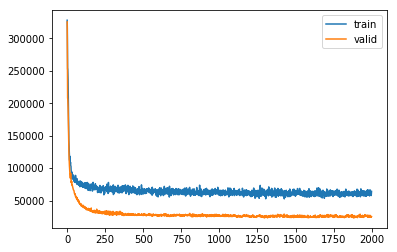

In [20]:
history3 = model3.fit(train_3, labels_3, nb_epoch=2000, batch_size=256,validation_data=(test_3, test_labels_3), verbose=2,shuffle=False)
# plot history
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [126]:
model3.save('my_model_10.h5')  

In [97]:
from keras.models import load_model
model3 = load_model('my_model_10.h5')

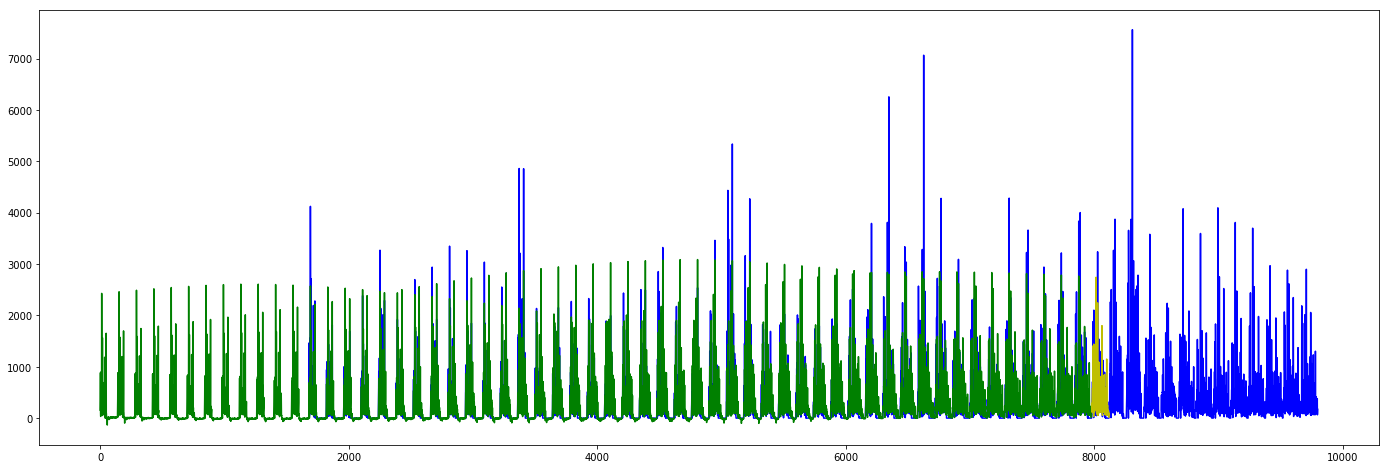

In [21]:
plt.figure(figsize=(24,8))
train_predict3 = model3.predict(train_3)
valid_predict3 = model3.predict(test_3)
#test_predict = model.predict(test_X)
plt.plot(labels[:-140], c='b')
plt.plot([x for x in train_predict3], c='g')
plt.plot([None for _ in train_predict3] + [x for x in valid_predict3], c='y')
#plt.plot([None for _ in train_predict] + [None for _ in valid_predict] + [x for x in test_predict], c='r')
plt.show()

In [22]:
import scipy as sp

In [23]:
sp.sqrt(sp.mean((valid_predict3.reshape(-1,) - test_labels_3) ** 2))

159.6283903673677

In [74]:
valid_predict3

array([[ 235.2095  ],
       [ 176.02602 ],
       [ 185.65567 ],
       [ 217.81772 ],
       [ 121.10798 ],
       [ 309.6761  ],
       [ 335.7842  ],
       [ 492.41434 ],
       [ 207.87378 ],
       [ 510.73734 ],
       [ 463.95374 ],
       [1285.8934  ],
       [ 595.07983 ],
       [ 514.87225 ],
       [ 142.24657 ],
       [ 525.6111  ],
       [  41.757893],
       [1333.622   ],
       [1209.8331  ],
       [ 308.50034 ],
       [ 216.18268 ],
       [ 167.0645  ],
       [ 220.17163 ],
       [ 203.0039  ],
       [ 134.66754 ],
       [ 294.83295 ],
       [ 381.02505 ],
       [ 245.26605 ],
       [ 415.82867 ],
       [ 404.83398 ],
       [ 386.85474 ],
       [ 505.07413 ],
       [ 180.59628 ],
       [ 278.7617  ],
       [ 221.54224 ],
       [ 445.6651  ],
       [2535.7488  ],
       [ 250.41785 ],
       [ 287.0181  ],
       [ 524.68353 ],
       [  92.66636 ],
       [ 134.71318 ],
       [ 244.61093 ],
       [ 433.25558 ],
       [ 194.02515 ],
       [ 6

In [100]:
ggg=np.array([1,2,3])

In [101]:
sp.mean(ggg)

2.0